In [1967]:
import pandas as pd
import numpy as np
import math as math
import statistics
from sklearn.linear_model import LogisticRegression
import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_decision_regions
import time
import copy
import textwrap
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',500)
pd.set_option('max_colwidth',1000)
pd.set_option('display.width', 150)

# Glossary.csv SOURCED FROM:
https://www.nba.com/stats/help/glossary

In [1850]:
glossaryDF = pd.read_csv('/Users/olutosinfashusi/jupyter/csv/Glossary.csv')
glossaryDict = {}
for i in range(len(glossaryDF)):
    stringInRow = glossaryDF.iloc[i].values[0]
    if stringInRow == 'Name':
        feature = glossaryDF.iloc[i-1].values[0]
        feature = feature.upper()
        glossaryDict[feature] = {}
        glossaryDict[feature]['Name'] = {}
        glossaryDict[feature]['Name'] = glossaryDF.iloc[i+1].values[0]
        glossaryDict[feature]['Definition'] = {}
        glossaryDict[feature]['Definition'] = glossaryDF.iloc[i+3].values[0]
        glossaryDict[feature]['Type'] = {}
        glossaryDict[feature]['Type'] = glossaryDF.iloc[i+5].values[0]
        glossaryDict[feature]['Contexts'] = {}
        
#FEATURES NOT IN https://www.nba.com/stats/help/glossary
glossaryDict['H/A'] = {}
glossaryDict['H/A']['Name'] = 'IS TEAM PLAYING HOME OR AWAY'
glossaryDict['H/A']['Definition'] = '0:HOME 1:AWAY'

glossaryDict['PTSA'] = {}
glossaryDict['PTSA']['Name'] = 'Points Allowed'
glossaryDict['PTSA']['Definition'] = 'The number of points allowed'

glossaryDict['PTSDELTA'] = {}
glossaryDict['PTSDELTA']['Name'] = 'Points Scored - Points Allowed'
glossaryDict['PTSDELTA']['Definition'] = 'Points Scored - Points Allowed'

glossaryDict['DAYSOFF'] = {}
glossaryDict['DAYSOFF']['Name'] = 'Number of days since last game'
glossaryDict['DAYSOFF']['Definition'] = 'Number of days since last game'

glossaryDict['W%'] = {}
glossaryDict['W%']['Name'] = 'The percentage of games played that a player or team has won'
glossaryDict['W%']['Definition'] = 'The percentage of games played that a player or team has won'

glossaryDict['L%'] = {}
glossaryDict['L%']['Name'] = 'The percentage of games played that a player or team has lost'
glossaryDict['L%']['Definition'] = 'The percentage of games played that a player or team has lost'

In [4]:
def convertDateColumn(df):
    locationToInsert = df.columns.get_loc('DATE')+1
    dates = pd.to_datetime(df['DATE'],format="%m/%d/%y").dt.date
    df = df.drop(columns='DATE')
    df.insert(locationToInsert,'DATE',dates)
    df = df.sort_values(by=['DATE','GAMEID']).reset_index(drop=True)
    return df
def featureEngineering(boxScoreType,df):
    if boxScoreType == 'TRADITIONAL':
        featuresToAddDict = {'OPPT':[],'PTSA':[],'2FGA':[],'2FGM':[],'2FG%':[],
                             'RESULT':[],'PTSDELTA':[],'H/A':[]}
        for i in range(len(df)):
            featuresToAddDict['OPPT'].append(df.iloc[i]['MATCH'][-3:])
            if i % 2 == 0: featuresToAddDict['PTSA'].append(df.iloc[i+1]['PTS'])
            else: featuresToAddDict['PTSA'].append(df.iloc[i-1]['PTS'])
            if df['W/L'][i] == 'L': featuresToAddDict['RESULT'].append(0)
            else: featuresToAddDict['RESULT'].append(1)
            featuresToAddDict['H/A'].append(df['MATCH'][i].count('vs'))
        df.insert(df.columns.get_loc('TEAM')+1,'OPPT',featuresToAddDict['OPPT'])
        df.insert(df.columns.get_loc('PTS')+1,'PTSA',featuresToAddDict['PTSA'])
        df.insert(df.columns.get_loc('FG%')+1,'2FGM',df['FGM'] - df['3PM'])
        df.insert(df.columns.get_loc('FG%')+1,'2FGA',df['FGA'] - df['3PA']) 
        df.insert(df.columns.get_loc('FG%')+1,'2FG%',df['2FGM']/df['2FGA'])
        df.insert(df.columns.get_loc('W/L')+1,'RESULT',featuresToAddDict['RESULT'])
        df = df.drop(columns=['W/L'])
        df.insert(df.columns.get_loc('PTSA')+1,'PTSDELTA',df['PTS']-df['PTSA'])
        df.insert(df.columns.get_loc('DATE')+1,'H/A',featuresToAddDict['H/A'])
        return df
    else:
        featuresToAddDict = {"OPPT":[],"RESULT":[],"H/A":[]}
        for i in range(len(df)):
            featuresToAddDict["OPPT"].append(df.iloc[i]['MATCH'][-3:])
            if df['W/L'][i] == 'L': featuresToAddDict["RESULT"].append(0)
            else: featuresToAddDict["RESULT"].append(1)
            featuresToAddDict["H/A"].append(df['MATCH'][i].count('vs'))
        df.insert(df.columns.get_loc('TEAM')+1,'OPPT',featuresToAddDict["OPPT"])
        df.insert(df.columns.get_loc('W/L')+1,'RESULT',featuresToAddDict["RESULT"])
        df = df.drop(columns=['W/L'])
        df.insert(df.columns.get_loc('DATE')+1,'H/A',featuresToAddDict["H/A"])
        return df
def addDaysOff(teamsDict):
    for team in list(teamsDict.keys()):
        daysOff = []
        daysOff.append(np.nan)
        for i in range(1,len(teamsDict[team]['DATE'])):
            date = teamsDict[team]['DATE'][i]
            prevDate = teamsDict[team]['DATE'][i-1] + datetime.timedelta(1)
            daysOff.append((date - prevDate).days)
        teamsDict[team]['DAYSOFF'] = daysOff
def addAdditionalFeatures(df,teamsDict):
    teams = []
    for team in list(teamsDict.keys()):
        teamDF = df[df['TEAM'] == team]
        startingIndex = len(list(df.columns))
        additionalFeatures = list(teamsDict[team].keys())[startingIndex:]
        for feature in additionalFeatures:
            teamDF = pd.concat([teamDF,
                                pd.DataFrame(teamsDict[team][feature],columns=[feature],index=teamDF.index.values)],axis=1)
        teams.append(teamDF)
    return pd.concat(teams)

def getTeamData(boxScoreType,df):
    teamsDict = {}
    features = df.columns.values
    
    if boxScoreType == 'TRADITIONAL': additionalFeatures = ['Ws','Ls','GP','W%','L%','AVGPTS','AVGPTSA']
    else: additionalFeatures = ['GP']
    for team in np.unique(df['TEAM']):
        teamsDict[team] = {}
    for team in np.unique(df['TEAM']):
        for feature in features:
            teamsDict[team][feature] = []
        for feature in additionalFeatures:
            teamsDict[team][feature] = []
    for i in range(len(df)):
        for feature in features:
            team = df.iloc[i]['TEAM']
            teamsDict[team][feature].append(df.iloc[i][feature])
        for feature in additionalFeatures:
            if feature == 'Ws': teamsDict[team][feature].append(teamsDict[team]['RESULT'].count(1))
            if feature == 'Ls': teamsDict[team][feature].append(teamsDict[team]['RESULT'].count(0))
            if feature == 'GP': teamsDict[team][feature].append(len(teamsDict[team]['RESULT']))
            if feature == 'W%': teamsDict[team][feature].append(teamsDict[team]['Ws'][-1]/teamsDict[team]['GP'][-1])
            if feature == 'L%': teamsDict[team][feature].append(teamsDict[team]['Ls'][-1]/teamsDict[team]['GP'][-1])
            if feature == 'AVGPTS': teamsDict[team][feature].append(np.mean(teamsDict[team]['PTS']))
            if feature == 'AVGPTSA': teamsDict[team][feature].append(np.mean(teamsDict[team]['PTSA']))
    return teamsDict

def addMovingAverageLx(featureStringsDict,teamDict,x):
    for team in list(teamsDict.keys()):
        for feature in featureStringsDict.keys():
            ma = []
            for _ in range(x): ma.append(np.nan)
            for maRange in range(0,len(teamsDict[team][feature])-x):
                ma.append(np.mean(teamsDict[team][feature][maRange:(x+maRange)]))
            teamsDict[team][featureStringsDict[feature].replace('x',str(x))] = ma
                
def addPercentMovingAverageLx(featureStringsDict,teamsDict,x):
    for team in list(teamsDict.keys()):
        for features in featureStringsDict.keys():
            ma = []
            for _ in range(x): ma.append(np.nan)
            for maRange in range(0,len(teamsDict[team][features[0]])-x):
                num = np.sum(teamsDict[team][features[0]][maRange:(x+maRange)])
                dem = np.sum(teamsDict[team][features[1]][maRange:(x+maRange)])
                ma.append(num/dem)
            teamsDict[team][featureStringsDict[features].replace('x',str(x))] = ma

# Traditional.csv SOURCED FROM:
https://www.nba.com/stats/teams/boxscores-traditional?Season=2023-24&SeasonType=Regular%20Season&dir=A&sort=GDATE

In [1786]:
start_time = time.time()
traditionalDF = pd.read_csv('/Users/olutosinfashusi/jupyter/csv/fromNBADOTCOM/2023-24/byGame/Traditional.csv')
traditionalDF = convertDateColumn(traditionalDF)
traditionalDF = featureEngineering('TRADITIONAL',traditionalDF)
teamsDict = getTeamData('TRADITIONAL',traditionalDF)
originalTraditionalColumns = ['TEAM','MATCH UP','GAME DATE','W/L','MIN','PTS','FGM',
                              'FGA','FG%','3PM','3PA','3P%','FTM','FTA','FT%','OREB',
                              'DREB','REB','AST','STL','BLK','TOV','PF','+/-']
print("%s seconds" % (time.time() - start_time))

34.77503705024719 seconds


In [6]:
start_time = time.time()
features = ['PTS','PTSA','PTSDELTA','FGM','FGA','2FGA','2FGM','3PM','3PA','FTM','FTA','OREB',
            'DREB','REB','AST','STL','BLK','TOV','PF']
featureStringsDict = {}
for feature in features: featureStringsDict[feature] = feature+'LxMA'
addMovingAverageLx(featureStringsDict,teamsDict,5)
addMovingAverageLx(featureStringsDict,teamsDict,4)
addMovingAverageLx(featureStringsDict,teamsDict,3)
addMovingAverageLx(featureStringsDict,teamsDict,2)
addMovingAverageLx(featureStringsDict,teamsDict,1)


features = [('FGM','FGA'),('2FGM','2FGA'),('3PM','3PA'),('FTM','FTA'),('Ws','GP')]
featureStringsDict = {}

for feature in features:
    if feature == ('FGM','FGA'): featureStringsDict[feature] = 'FG%LxMA'
    if feature == ('2FGM','2FGA'): featureStringsDict[feature] = '2FG%LxMA'
    if feature == ('3PM','3PA'): featureStringsDict[feature] = '3P%LxMA'
    if feature == ('FTM','FTA'): featureStringsDict[feature] = 'FT%LxMA'
    if feature == ('Ws','GP'): featureStringsDict[feature] = 'W%LxMA'
        
addPercentMovingAverageLx(featureStringsDict,teamsDict,5)
addPercentMovingAverageLx(featureStringsDict,teamsDict,4)
addPercentMovingAverageLx(featureStringsDict,teamsDict,3)
addPercentMovingAverageLx(featureStringsDict,teamsDict,2)
addPercentMovingAverageLx(featureStringsDict,teamsDict,1)

addDaysOff(teamsDict)
traditionalDF = addAdditionalFeatures(traditionalDF,teamsDict)
traditionalDF = traditionalDF.sort_values(by=['DATE','GAMEID','H/A']).reset_index(drop=True)
print("%s seconds" % (time.time() - start_time))

<ipython-input-4-8b2e36489fd7>:106: RuntimeWarning: invalid value encountered in scalar divide
  ma.append(num/dem)


17.5640230178833 seconds


In [7]:
print('In rare occasion on 4/9/24 Celtics attempted 0 free throws vs Bucks')
print('Causing a warning while calculating Celtics FT%L1MA')
print('FT%L1MA feature is not used during ... ')
traditionalDF[traditionalDF['FTA'] == 0]

In rare occasion on 4/9/24 Celtics attempted 0 free throws vs Bucks [see below]
Causing a warning while calculating Celtics FT%L1MA
FT%L1MA feature is not used during ... 


,TEAM,OPPT,TEAMID,MATCH,GAMEID,RESULT,DATE,H/A,SPREAD,O/U,MIN,PTS,PTSA,PTSDELTA,FGM,FGA,FG%,2FG%,2FGA,2FGM,3PM,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,PF,+/-,Ws,Ls,GP,W%,L%,AVGPTS,AVGPTSA,PTSL5MA,PTSAL5MA,PTSDELTAL5MA,FGML5MA,FGAL5MA,2FGAL5MA,2FGML5MA,3PML5MA,3PAL5MA,FTML5MA,FTAL5MA,OREBL5MA,DREBL5MA,REBL5MA,ASTL5MA,STLL5MA,BLKL5MA,TOVL5MA,PFL5MA,PTSL4MA,PTSAL4MA,PTSDELTAL4MA,FGML4MA,FGAL4MA,2FGAL4MA,2FGML4MA,3PML4MA,3PAL4MA,FTML4MA,FTAL4MA,OREBL4MA,DREBL4MA,REBL4MA,ASTL4MA,STLL4MA,BLKL4MA,TOVL4MA,PFL4MA,PTSL3MA,PTSAL3MA,PTSDELTAL3MA,FGML3MA,FGAL3MA,2FGAL3MA,2FGML3MA,3PML3MA,3PAL3MA,FTML3MA,FTAL3MA,OREBL3MA,DREBL3MA,REBL3MA,ASTL3MA,STLL3MA,BLKL3MA,TOVL3MA,PFL3MA,PTSL2MA,PTSAL2MA,PTSDELTAL2MA,FGML2MA,FGAL2MA,2FGAL2MA,2FGML2MA,3PML2MA,3PAL2MA,FTML2MA,FTAL2MA,OREBL2MA,DREBL2MA,REBL2MA,ASTL2MA,STLL2MA,BLKL2MA,TOVL2MA,PFL2MA,PTSL1MA,PTSAL1MA,PTSDELTAL1MA,FGML1MA,FGAL1MA,2FGAL1MA,2FGML1MA,3PML1MA,3PAL1MA,FTML1MA,FTAL1MA,OREBL1MA,DREBL1MA,REBL1MA,ASTL1MA,STLL1MA,BLKL1MA,TOVL1MA,PFL1MA,FG%L5MA,2FG%L5MA,3P%L5MA,FT%L5MA,W%L5MA,FG%L4MA,2FG%L4MA,3P%L4MA,FT%L4MA,W%L4MA,FG%L3MA,2FG%L3MA,3P%L3MA,FT%L3MA,W%L3MA,FG%L2MA,2FG%L2MA,3P%L2MA,FT%L2MA,W%L2MA,FG%L1MA,2FG%L1MA,3P%L1MA,FT%L1MA,W%L1MA,DAYSOFF
2354,BOS,MIL,1610612738,BOS @ MIL,22301148,0,2024-04-09,0,3.5,231.0,240,91,104,-13,37,93,39.8,0.487805,41,20,17,52,32.7,0,0,0.0,12,26,38,27,11,4,12,8,-13,62,17,79,0.78481,0.21519,120.443038,109.101266,116.4,100.6,15.8,43.8,87.8,45.4,28.0,15.8,42.4,13.0,15.6,9.4,38.4,47.8,29.4,6.8,6.4,11.2,13.8,119.5,102.75,16.75,45.0,89.25,45.5,29.0,16.0,43.75,13.5,16.5,9.75,37.25,47.0,30.0,6.75,6.25,10.75,14.0,120.0,102.333333,17.666667,45.666667,89.333333,48.666667,30.666667,15.0,40.666667,13.666667,16.666667,9.333333,36.333333,45.666667,30.666667,8.0,7.333333,10.666667,13.666667,112.5,103.5,9.0,43.5,88.0,47.0,29.5,14.0,41.0,11.5,15.5,8.5,37.0,45.5,29.5,8.5,6.0,10.5,11.5,124.0,107.0,17.0,49.0,87.0,49.0,33.0,16.0,38.0,10.0,13.0,5.0,35.0,40.0,34.0,11.0,8.0,13.0,12.0,0.498861,0.61674,0.372642,0.833333,0.789474,0.504202,0.637363,0.365714,0.818182,0.79085,0.511194,0.630137,0.368852,0.82,0.792208,0.494318,0.62766,0.341463,0.741935,0.793548,0.563218,0.673469,0.421053,0.769231,0.794872,1.0


In [8]:
traditionalFeatures = list(traditionalDF.columns)
columnsToRemove = np.array(['TEAM','OPPT','TEAMID','MATCH','GAMEID','RESULT','DATE',
                            'SPREAD','O/U','MIN','PTS','PTSA','PTSDELTA','FGM','FGA','FG%',
                            '2FG%','2FGA','2FGM','3PM','3PA','3P%','FTM','FTA','FT%','OREB',
                            'DREB','REB','AST','STL','BLK','TOV','PF','+/-','Ws','Ls', 'GP',
                            'W%', 'L%', 'AVGPTS','AVGPTSA'])
for feature in columnsToRemove: traditionalFeatures.remove(feature)
print(traditionalFeatures)

['H/A', 'PTSL5MA', 'PTSAL5MA', 'PTSDELTAL5MA', 'FGML5MA', 'FGAL5MA', '2FGAL5MA', '2FGML5MA', '3PML5MA', '3PAL5MA', 'FTML5MA', 'FTAL5MA', 'OREBL5MA', 'DREBL5MA', 'REBL5MA', 'ASTL5MA', 'STLL5MA', 'BLKL5MA', 'TOVL5MA', 'PFL5MA', 'PTSL4MA', 'PTSAL4MA', 'PTSDELTAL4MA', 'FGML4MA', 'FGAL4MA', '2FGAL4MA', '2FGML4MA', '3PML4MA', '3PAL4MA', 'FTML4MA', 'FTAL4MA', 'OREBL4MA', 'DREBL4MA', 'REBL4MA', 'ASTL4MA', 'STLL4MA', 'BLKL4MA', 'TOVL4MA', 'PFL4MA', 'PTSL3MA', 'PTSAL3MA', 'PTSDELTAL3MA', 'FGML3MA', 'FGAL3MA', '2FGAL3MA', '2FGML3MA', '3PML3MA', '3PAL3MA', 'FTML3MA', 'FTAL3MA', 'OREBL3MA', 'DREBL3MA', 'REBL3MA', 'ASTL3MA', 'STLL3MA', 'BLKL3MA', 'TOVL3MA', 'PFL3MA', 'PTSL2MA', 'PTSAL2MA', 'PTSDELTAL2MA', 'FGML2MA', 'FGAL2MA', '2FGAL2MA', '2FGML2MA', '3PML2MA', '3PAL2MA', 'FTML2MA', 'FTAL2MA', 'OREBL2MA', 'DREBL2MA', 'REBL2MA', 'ASTL2MA', 'STLL2MA', 'BLKL2MA', 'TOVL2MA', 'PFL2MA', 'PTSL1MA', 'PTSAL1MA', 'PTSDELTAL1MA', 'FGML1MA', 'FGAL1MA', '2FGAL1MA', '2FGML1MA', '3PML1MA', '3PAL1MA', 'FTML1MA', 'F

# Advanced.csv SOURCED FROM:
https://www.nba.com/stats/teams/boxscores-advanced?Season=2023-24&SeasonType=Regular%20Season&dir=A&sort=GDATE

In [1785]:
start_time = time.time()
advancedDF = pd.read_csv('/Users/olutosinfashusi/jupyter/csv/fromNBADOTCOM/2023-24/byGame/Advanced.csv')
advancedDF = convertDateColumn(advancedDF)
advancedDF = featureEngineering('ADVANCED',advancedDF)
teamsDict = getTeamData('ADVANCED',advancedDF)
print("%s seconds" % (time.time() - start_time))
originalAdvancedColumns = ['TEAM','MATCH UP','GAME DATE','W/L','MIN','OFFRTG',
                           'DEFRTG','NETRTG','AST%','AST/TO','AST RATIO','OREB%',
                           'DREB%','REB%','TOV%','EFG%','TS%','PACE','PIE']

24.05783700942993 seconds
['TEAM', 'MATCH UP', 'GAME DATE', 'W/L', 'MIN', 'OFFRTG', 'DEFRTG', 'NETRTG', 'AST%', 'AST/TO', 'AST RATIO', 'OREB%', 'DREB%', 'REB%', 'TOV%', 'EFG%', 'TS%', 'PACE', 'PIE']


In [10]:
start_time = time.time()
features = ['OFFRTG','DEFRTG','NETRTG','AST%','AST/TO','AST RATIO','OREB%','DREB%','REB%','TOV%',
            'EFG%','TS%','PACE','PIE']
featureStringsDict = {}
for feature in features: featureStringsDict[feature] = feature+'LxMA' 
    
addMovingAverageLx(featureStringsDict,teamsDict,5)
addMovingAverageLx(featureStringsDict,teamsDict,4)
addMovingAverageLx(featureStringsDict,teamsDict,3)
addMovingAverageLx(featureStringsDict,teamsDict,2)
addMovingAverageLx(featureStringsDict,teamsDict,1)

advancedDF = addAdditionalFeatures(advancedDF,teamsDict)
advancedDF = advancedDF.sort_values(by=['DATE','GAMEID','H/A']).reset_index(drop=True)
print("%s seconds" % (time.time() - start_time))

8.503874063491821 seconds


In [11]:
advancedFeatures = list(advancedDF.columns)
columnsToRemove = np.array(['TEAM','OPPT','TEAMID','MATCH','GAMEID','RESULT','DATE',
                            'H/A','SPREAD','O/U','MIN','OFFRTG','DEFRTG','NETRTG',
                            'AST%','AST/TO','AST RATIO','OREB%','DREB%','REB%','TOV%',
                            'EFG%','TS%','PACE','PIE','GP'])
for feature in columnsToRemove: advancedFeatures.remove(feature)
print(advancedFeatures)

['OFFRTGL5MA', 'DEFRTGL5MA', 'NETRTGL5MA', 'AST%L5MA', 'AST/TOL5MA', 'AST RATIOL5MA', 'OREB%L5MA', 'DREB%L5MA', 'REB%L5MA', 'TOV%L5MA', 'EFG%L5MA', 'TS%L5MA', 'PACEL5MA', 'PIEL5MA', 'OFFRTGL4MA', 'DEFRTGL4MA', 'NETRTGL4MA', 'AST%L4MA', 'AST/TOL4MA', 'AST RATIOL4MA', 'OREB%L4MA', 'DREB%L4MA', 'REB%L4MA', 'TOV%L4MA', 'EFG%L4MA', 'TS%L4MA', 'PACEL4MA', 'PIEL4MA', 'OFFRTGL3MA', 'DEFRTGL3MA', 'NETRTGL3MA', 'AST%L3MA', 'AST/TOL3MA', 'AST RATIOL3MA', 'OREB%L3MA', 'DREB%L3MA', 'REB%L3MA', 'TOV%L3MA', 'EFG%L3MA', 'TS%L3MA', 'PACEL3MA', 'PIEL3MA', 'OFFRTGL2MA', 'DEFRTGL2MA', 'NETRTGL2MA', 'AST%L2MA', 'AST/TOL2MA', 'AST RATIOL2MA', 'OREB%L2MA', 'DREB%L2MA', 'REB%L2MA', 'TOV%L2MA', 'EFG%L2MA', 'TS%L2MA', 'PACEL2MA', 'PIEL2MA', 'OFFRTGL1MA', 'DEFRTGL1MA', 'NETRTGL1MA', 'AST%L1MA', 'AST/TOL1MA', 'AST RATIOL1MA', 'OREB%L1MA', 'DREB%L1MA', 'REB%L1MA', 'TOV%L1MA', 'EFG%L1MA', 'TS%L1MA', 'PACEL1MA', 'PIEL1MA']


# FourFactors.csv SOURCED FROM: </b>
https://www.nba.com/stats/teams/boxscores-four-factors?Season=2023-24&SeasonType=Regular%20Season&dir=A&sort=GDATE

In [1847]:
start_time = time.time()
fourFactorsDF = pd.read_csv('/Users/olutosinfashusi/jupyter/csv/2023-24/FourFactors.csv')
fourFactorsDF = convertDateColumn(fourFactorsDF)
fourFactorsDF = featureEngineering('FOURFACTORS',fourFactorsDF)
teamsDict = getTeamData('FOURFACTORS',fourFactorsDF)
print("%s seconds" % (time.time() - start_time))
originalFourFactorsColumns = ['TEAM','MATCH UP','GAME DATE','W/L','MIN','EFG%',
                              'FTA RATE','TOV%','OREB%','OPP EFG%','OPP FTA RATE',
                              'OPP TOV%','OPP OREB%']

17.455270290374756 seconds


In [13]:
start_time = time.time()
features = ['EFG%','FTA RATE','TOV%','OREB%','OPP EFG%','OPP FTA RATE','OPP TOV%','OPP OREB%']
featureStringsDict = {}
for feature in features: featureStringsDict[feature] = feature+'LxMA' 
    
addMovingAverageLx(featureStringsDict,teamsDict,5)
addMovingAverageLx(featureStringsDict,teamsDict,4)
addMovingAverageLx(featureStringsDict,teamsDict,3)
addMovingAverageLx(featureStringsDict,teamsDict,2)
addMovingAverageLx(featureStringsDict,teamsDict,1)

fourFactorsDF = addAdditionalFeatures(fourFactorsDF,teamsDict)
fourFactorsDF = fourFactorsDF.sort_values(by=['DATE','GAMEID','H/A']).reset_index(drop=True)
print("%s seconds" % (time.time() - start_time))

4.666632890701294 seconds


In [14]:
fourFactorsFeatures = list(fourFactorsDF.columns)
columnsToRemove = np.array(['TEAM','OPPT','TEAMID','MATCH','GAMEID','RESULT','DATE','H/A',
                            'SPREAD','O/U','MIN','EFG%','FTA RATE','TOV%','OREB%','OPP EFG%',
                            'OPP FTA RATE','OPP TOV%','OPP OREB%','GP'])
for feature in columnsToRemove: fourFactorsFeatures.remove(feature)
print(fourFactorsFeatures)

['EFG%L5MA', 'FTA RATEL5MA', 'TOV%L5MA', 'OREB%L5MA', 'OPP EFG%L5MA', 'OPP FTA RATEL5MA', 'OPP TOV%L5MA', 'OPP OREB%L5MA', 'EFG%L4MA', 'FTA RATEL4MA', 'TOV%L4MA', 'OREB%L4MA', 'OPP EFG%L4MA', 'OPP FTA RATEL4MA', 'OPP TOV%L4MA', 'OPP OREB%L4MA', 'EFG%L3MA', 'FTA RATEL3MA', 'TOV%L3MA', 'OREB%L3MA', 'OPP EFG%L3MA', 'OPP FTA RATEL3MA', 'OPP TOV%L3MA', 'OPP OREB%L3MA', 'EFG%L2MA', 'FTA RATEL2MA', 'TOV%L2MA', 'OREB%L2MA', 'OPP EFG%L2MA', 'OPP FTA RATEL2MA', 'OPP TOV%L2MA', 'OPP OREB%L2MA', 'EFG%L1MA', 'FTA RATEL1MA', 'TOV%L1MA', 'OREB%L1MA', 'OPP EFG%L1MA', 'OPP FTA RATEL1MA', 'OPP TOV%L1MA', 'OPP OREB%L1MA']


# Misc.csv SOURCED FROM: </b>
https://www.nba.com/stats/teams/boxscores-misc?Season=2023-24&SeasonType=Regular%20Season&dir=A&sort=GDATE

In [1981]:
start_time = time.time()
miscDF = pd.read_csv('/Users/olutosinfashusi/jupyter/csv/Misc.csv')
miscDF = convertDateColumn(miscDF)
miscDF = featureEngineering('MISC',miscDF)
teamsDict = getTeamData('MISC',miscDF)
originalMiscColumns = ['TEAM','MATCH UP','GAME DATE','W/L','MIN','PTS OFF TO',
                       '2ND PTS','FBPS','PITP','OPP PTS OFF TO','OPP 2ND PTS',
                       'OPP FBPS','OPP PITP']
print("%s seconds" % (time.time() - start_time))

17.290331840515137 seconds


In [1982]:
start_time = time.time()
features = ['PTS OFF TO','2ND PTS','FBPS','PITP','OPP PTS OFF TO','OPP 2ND PTS','OPP FBPS','OPP PITP']
featureStringsDict = {}
for feature in features: featureStringsDict[feature] = feature+'LxMA' 
featureStringsDict    
addMovingAverageLx(featureStringsDict,teamsDict,5)
addMovingAverageLx(featureStringsDict,teamsDict,4)
addMovingAverageLx(featureStringsDict,teamsDict,3)
addMovingAverageLx(featureStringsDict,teamsDict,2)
addMovingAverageLx(featureStringsDict,teamsDict,1)

miscDF = addAdditionalFeatures(miscDF,teamsDict)
miscDF = miscDF.sort_values(by=['DATE','GAMEID','H/A']).reset_index(drop=True)
print("%s seconds" % (time.time() - start_time))

4.815891981124878 seconds


In [1983]:
miscFeatures = list(miscDF.columns)
columnsToRemove = np.array(['TEAM','OPPT','TEAMID','MATCH','GAMEID','RESULT','DATE','H/A','SPREAD',
                            'O/U','MIN','PTS OFF TO','2ND PTS','FBPS','PITP','OPP PTS OFF TO',
                            'OPP 2ND PTS','OPP FBPS','OPP PITP','GP'])
for feature in columnsToRemove: miscFeatures.remove(feature)
print(miscFeatures)

['PTS OFF TOL5MA', '2ND PTSL5MA', 'FBPSL5MA', 'PITPL5MA', 'OPP PTS OFF TOL5MA', 'OPP 2ND PTSL5MA', 'OPP FBPSL5MA', 'OPP PITPL5MA', 'PTS OFF TOL4MA', '2ND PTSL4MA', 'FBPSL4MA', 'PITPL4MA', 'OPP PTS OFF TOL4MA', 'OPP 2ND PTSL4MA', 'OPP FBPSL4MA', 'OPP PITPL4MA', 'PTS OFF TOL3MA', '2ND PTSL3MA', 'FBPSL3MA', 'PITPL3MA', 'OPP PTS OFF TOL3MA', 'OPP 2ND PTSL3MA', 'OPP FBPSL3MA', 'OPP PITPL3MA', 'PTS OFF TOL2MA', '2ND PTSL2MA', 'FBPSL2MA', 'PITPL2MA', 'OPP PTS OFF TOL2MA', 'OPP 2ND PTSL2MA', 'OPP FBPSL2MA', 'OPP PITPL2MA', 'PTS OFF TOL1MA', '2ND PTSL1MA', 'FBPSL1MA', 'PITPL1MA', 'OPP PTS OFF TOL1MA', 'OPP 2ND PTSL1MA', 'OPP FBPSL1MA', 'OPP PITPL1MA']


# Scoring.csv SOURCED FROM: </b>
https://www.nba.com/stats/teams/boxscores-scoring?Season=2023-24&SeasonType=Regular%20Season&dir=A&sort=GDATE

In [1852]:
start_time = time.time()
scoringDF = pd.read_csv('/Users/olutosinfashusi/jupyter/csv/Scoring.csv')
scoringDF = convertDateColumn(scoringDF)
scoringDF = featureEngineering('SCORING',scoringDF)
teamsDict = getTeamData('SCORING',scoringDF)
print(scoringDF.columns)
print("%s seconds" % (time.time() - start_time))
originalScoringColumns = ['TEAM','MATCH UP','GAME DATE','W/L','MIN','%FGA 2PT','%FGA 3PT',
                          '%PTS 2PT','%PTS 2PT MR','%PTS 3PT','%PTS FBPS','%PTS FT',
                          '%PTS OFF TO','%PTS PITP','2FGM %AST','2FGM %UAST',
                          '3FGM %AST','3FGM %UAST','FGM %AST','FGM %UAST']

Index(['TEAM', 'OPPT', 'TEAMID', 'MATCH', 'GAMEID', 'RESULT', 'DATE', 'H/A', 'SPREAD', 'O/U', 'MIN', '%FGA 2PT', '%FGA 3PT', '%PTS 2PT',
       '%PTS 2PT MR', '%PTS 3PT', '%PTS FBPS', '%PTS FT', '%PTS OFF TO', '%PTS PITP', '2FGM %AST', '2FGM %UAST', '3FGM %AST', '3FGM %UAST',
       'FGM %AST', 'FGM %UAST'],
      dtype='object')
25.788572072982788 seconds


In [19]:
start_time = time.time()
features = ['%FGA 2PT','%FGA 3PT','%PTS 2PT','%PTS 2PT MR','%PTS 3PT','%PTS FBPS','%PTS FT',
            '%PTS OFF TO','%PTS PITP','2FGM %AST','2FGM %UAST','3FGM %AST','3FGM %UAST','FGM %AST','FGM %UAST']
featureStringsDict = {}
for feature in features: featureStringsDict[feature] = feature+'LxMA' 
featureStringsDict    
addMovingAverageLx(featureStringsDict,teamsDict,5)
addMovingAverageLx(featureStringsDict,teamsDict,4)
addMovingAverageLx(featureStringsDict,teamsDict,3)
addMovingAverageLx(featureStringsDict,teamsDict,2)
addMovingAverageLx(featureStringsDict,teamsDict,1)

scoringDF = addAdditionalFeatures(scoringDF,teamsDict)
scoringDF = scoringDF.sort_values(by=['DATE','GAMEID','H/A']).reset_index(drop=True)
print("%s seconds" % (time.time() - start_time))

11.98450779914856 seconds


In [20]:
scoringFeatures = list(scoringDF.columns)
columnsToRemove = np.array(['TEAM','OPPT','TEAMID','MATCH','GAMEID','RESULT','DATE','H/A','SPREAD',
                            'O/U','MIN','%FGA 2PT','%FGA 3PT','%PTS 2PT','%PTS 2PT MR','%PTS 3PT',
                            '%PTS FBPS','%PTS FT','%PTS OFF TO','%PTS PITP','2FGM %AST','2FGM %UAST',
                            '3FGM %AST','3FGM %UAST','FGM %AST','FGM %UAST','GP'])
for feature in columnsToRemove: scoringFeatures.remove(feature)
print(scoringFeatures)

['%FGA 2PTL5MA', '%FGA 3PTL5MA', '%PTS 2PTL5MA', '%PTS 2PT MRL5MA', '%PTS 3PTL5MA', '%PTS FBPSL5MA', '%PTS FTL5MA', '%PTS OFF TOL5MA', '%PTS PITPL5MA', '2FGM %ASTL5MA', '2FGM %UASTL5MA', '3FGM %ASTL5MA', '3FGM %UASTL5MA', 'FGM %ASTL5MA', 'FGM %UASTL5MA', '%FGA 2PTL4MA', '%FGA 3PTL4MA', '%PTS 2PTL4MA', '%PTS 2PT MRL4MA', '%PTS 3PTL4MA', '%PTS FBPSL4MA', '%PTS FTL4MA', '%PTS OFF TOL4MA', '%PTS PITPL4MA', '2FGM %ASTL4MA', '2FGM %UASTL4MA', '3FGM %ASTL4MA', '3FGM %UASTL4MA', 'FGM %ASTL4MA', 'FGM %UASTL4MA', '%FGA 2PTL3MA', '%FGA 3PTL3MA', '%PTS 2PTL3MA', '%PTS 2PT MRL3MA', '%PTS 3PTL3MA', '%PTS FBPSL3MA', '%PTS FTL3MA', '%PTS OFF TOL3MA', '%PTS PITPL3MA', '2FGM %ASTL3MA', '2FGM %UASTL3MA', '3FGM %ASTL3MA', '3FGM %UASTL3MA', 'FGM %ASTL3MA', 'FGM %UASTL3MA', '%FGA 2PTL2MA', '%FGA 3PTL2MA', '%PTS 2PTL2MA', '%PTS 2PT MRL2MA', '%PTS 3PTL2MA', '%PTS FBPSL2MA', '%PTS FTL2MA', '%PTS OFF TOL2MA', '%PTS PITPL2MA', '2FGM %ASTL2MA', '2FGM %UASTL2MA', '3FGM %ASTL2MA', '3FGM %UASTL2MA', 'FGM %ASTL2MA', 

# INCREASING FEATURES AVAILABLE FROM 66 to 332

In [2176]:
print('ORIGINAL FEATURES:\n',np.unique(list(originalTraditionalColumns+
                                            originalAdvancedColumns+originalFourFactorsColumns+originalMiscColumns+originalScoringColumns)),'\n')
print('# OF ORIGINAL FEATURES:',len(np.unique(list(originalTraditionalColumns+originalAdvancedColumns+
                                                   originalFourFactorsColumns+originalMiscColumns+originalScoringColumns))))

ORIGINAL FEATURES:
 ['%FGA 2PT' '%FGA 3PT' '%PTS 2PT' '%PTS 2PT MR' '%PTS 3PT' '%PTS FBPS'
 '%PTS FT' '%PTS OFF TO' '%PTS PITP' '+/-' '2FGM %AST' '2FGM %UAST'
 '2ND PTS' '3FGM %AST' '3FGM %UAST' '3P%' '3PA' '3PM' 'AST' 'AST RATIO'
 'AST%' 'AST/TO' 'BLK' 'DEFRTG' 'DREB' 'DREB%' 'EFG%' 'FBPS' 'FG%' 'FGA'
 'FGM' 'FGM %AST' 'FGM %UAST' 'FT%' 'FTA' 'FTA RATE' 'FTM' 'GAME DATE'
 'MATCH UP' 'MIN' 'NETRTG' 'OFFRTG' 'OPP 2ND PTS' 'OPP EFG%' 'OPP FBPS'
 'OPP FTA RATE' 'OPP OREB%' 'OPP PITP' 'OPP PTS OFF TO' 'OPP TOV%' 'OREB'
 'OREB%' 'PACE' 'PF' 'PIE' 'PITP' 'PTS' 'PTS OFF TO' 'REB' 'REB%' 'STL'
 'TEAM' 'TOV' 'TOV%' 'TS%' 'W/L'] 

# OF ORIGINAL FEATURES: 66


In [2177]:
print('AVAILABLE FEATURES:\n',np.unique(list(traditionalFeatures+advancedFeatures+fourFactorsFeatures
                                   +miscFeatures+scoringFeatures)),'\n')
print('# OF AVAILABLE FEATURES:',len(np.unique(list(traditionalFeatures+advancedFeatures+fourFactorsFeatures
                                       +miscFeatures+scoringFeatures))))

AVAILABLE FEATURES:
 ['%FGA 2PTL1MA' '%FGA 2PTL2MA' '%FGA 2PTL3MA' '%FGA 2PTL4MA'
 '%FGA 2PTL5MA' '%FGA 3PTL1MA' '%FGA 3PTL2MA' '%FGA 3PTL3MA'
 '%FGA 3PTL4MA' '%FGA 3PTL5MA' '%PTS 2PT MRL1MA' '%PTS 2PT MRL2MA'
 '%PTS 2PT MRL3MA' '%PTS 2PT MRL4MA' '%PTS 2PT MRL5MA' '%PTS 2PTL1MA'
 '%PTS 2PTL2MA' '%PTS 2PTL3MA' '%PTS 2PTL4MA' '%PTS 2PTL5MA'
 '%PTS 3PTL1MA' '%PTS 3PTL2MA' '%PTS 3PTL3MA' '%PTS 3PTL4MA'
 '%PTS 3PTL5MA' '%PTS FBPSL1MA' '%PTS FBPSL2MA' '%PTS FBPSL3MA'
 '%PTS FBPSL4MA' '%PTS FBPSL5MA' '%PTS FTL1MA' '%PTS FTL2MA' '%PTS FTL3MA'
 '%PTS FTL4MA' '%PTS FTL5MA' '%PTS OFF TOL1MA' '%PTS OFF TOL2MA'
 '%PTS OFF TOL3MA' '%PTS OFF TOL4MA' '%PTS OFF TOL5MA' '%PTS PITPL1MA'
 '%PTS PITPL2MA' '%PTS PITPL3MA' '%PTS PITPL4MA' '%PTS PITPL5MA'
 '2FG%L1MA' '2FG%L2MA' '2FG%L3MA' '2FG%L4MA' '2FG%L5MA' '2FGAL1MA'
 '2FGAL2MA' '2FGAL3MA' '2FGAL4MA' '2FGAL5MA' '2FGM %ASTL1MA'
 '2FGM %ASTL2MA' '2FGM %ASTL3MA' '2FGM %ASTL4MA' '2FGM %ASTL5MA'
 '2FGM %UASTL1MA' '2FGM %UASTL2MA' '2FGM %UASTL3MA' '2FGM %UASTL4

In [1872]:
def trainOnPreviousGames(NBAdf,features,date,standardize):
    trainDF = NBAdf[(NBAdf['DATE'] < date) & (NBAdf['GP'] > 5)]
    teamsPlayingToday = list(NBAdf[NBAdf['DATE'] == date]['TEAM'])
    trainResultsDict = {}
    trainResultsDict[date] = {}
    for team in teamsPlayingToday:
        trainResultsDict[date][team] = {'DATE':datetime.date,'TEAM':str,'TRAIN SIZE':int,
                                        'FEATURE':[],'INTERCEPT':[],'COEF':[],'ODDS RATIO':[],
                                        'LOG LOSS':[]}
    for team in teamsPlayingToday:
        for feature in features:
            X_train = trainDF[trainDF['TEAM'] == team][feature]
            if X_train.isnull().values.any() == True:
                continue #skips the current iteration and proceeds to the next one
            X_train = np.array(X_train)
            X_train = np.reshape(X_train,(len(X_train),1))
            if (standardize): X_train = StandardScaler().fit_transform(X_train)
            y_train = trainDF[trainDF['TEAM'] == team]['RESULT']
            model = LogisticRegression(random_state=0)
            model.fit(X_train,y_train)
            trainResultsDict[date][team]['DATE'] = date
            trainResultsDict[date][team]['TEAM'] = team
            trainResultsDict[date][team]['TRAIN SIZE'] = len(X_train)
            trainResultsDict[date][team]['FEATURE'].append(feature),
            trainResultsDict[date][team]['INTERCEPT'].append(model.intercept_[0])
            trainResultsDict[date][team]['COEF'].append(model.coef_[0][0])
            trainResultsDict[date][team]['ODDS RATIO'].append(np.exp(model.coef_[0][0]))
            trainResultsDict[date][team]['LOG LOSS'].append(log_loss(y_train,model.predict_proba(X_train)))
    return trainResultsDict
def getHighestOddsRatioFeatures(trainResultsDict):
    highestOddsRatiosDF = pd.DataFrame()
    date = list(trainResultsDict.keys())[0]
    for key in trainResultsDict[date].keys():
        highestOddsRatiosDF = highestOddsRatiosDF.append(pd.DataFrame(trainResultsDict[date][key]).sort_values(by='ODDS RATIO',ascending=False).head(1).reset_index(drop=True))
    highestOddsRatiosDF = highestOddsRatiosDF.reset_index(drop=True)
    return highestOddsRatiosDF
def getLowestLogLossFeatures(trainResultsDict):
    lowestLogLossDF = pd.DataFrame()
    date = list(trainResultsDict.keys())[0]
    for key in trainResultsDict[date].keys():
         lowestLogLossDF = lowestLogLossDF.append(pd.DataFrame(trainResultsDict[date][key]).sort_values(by='LOG LOSS').head(1).reset_index(drop=True))
    lowestLogLossDF = lowestLogLossDF.reset_index(drop=True)
    return lowestLogLossDF.reset_index(drop=True)
def addTestDetails(NBAdf,date,testDetailsDF):
    NBAtest = NBAdf[NBAdf['DATE'] == date].reset_index(drop=True)
    teamsPlayingToday = NBAtest['TEAM'].values
    matchDetails = {'GAMEID':[],'TRUE X_test':[],'SPREAD':[],'ACTUAL RESULT':[]}
    for i in range(len(testDetailsDF)):
        matchDetails['GAMEID'].append(NBAtest.iloc[i]['GAMEID'])
        matchDetails['TRUE X_test'].append(NBAtest.iloc[i][testDetailsDF.iloc[i]['FEATURE']])
        matchDetails['SPREAD'].append(NBAtest.iloc[i]['SPREAD'])
        matchDetails['ACTUAL RESULT'].append(NBAtest.iloc[i]['RESULT'])
    testDetailsDF = pd.concat([testDetailsDF,
                    pd.DataFrame(matchDetails['GAMEID'],columns=['GAMEID']),
                    pd.DataFrame(matchDetails['TRUE X_test'],columns=['TRUE X_test']),
                    pd.DataFrame(matchDetails['SPREAD'],columns=['SPREAD']),
                    pd.DataFrame(matchDetails['ACTUAL RESULT'],columns=['ACTUAL RESULT']),],axis=1)
    testDetailsDF.insert(testDetailsDF.columns.get_loc('DATE')+1,'GAMEID',testDetailsDF.pop('GAMEID'))
    return testDetailsDF
def testGamesToday(NBAdf,testDetailsDF,date,standardize):
    NBAtrain = NBAdf[NBAdf['DATE'] < date].dropna()
    NBAtest = NBAdf[NBAdf['DATE'] == date].reset_index(drop=True)
    testDetails = {'PREDICT X_test':[],'PROBABILITY ESTIMATE':[],'T/S':[]}
    for i in range(len(testDetailsDF)):
        team = testDetailsDF.iloc[i]['TEAM']
        feature = testDetailsDF.iloc[i]['FEATURE']
        X_train = NBAtrain[NBAtrain['TEAM'] == team][feature]
        X_train = np.array(X_train)
        X_train = np.reshape(X_train,(len(X_train),1))
        if (standardize): 
            X_train = StandardScaler().fit_transform(X_train)
            testDetails['T/S'].append('S')
        else: testDetails['T/S'].append('T')
        y_train = NBAtrain[NBAtrain['TEAM'] == team]['RESULT']
        model = LogisticRegression(random_state=0)
        model.fit(X_train,y_train)
        X_test = np.array([testDetailsDF.iloc[i]['TRUE X_test']])
        if (standardize):
            X_train = NBAtrain[NBAtrain['TEAM'] == team][feature]
            X_test = (X_test - np.mean(X_train)) / np.std(X_train)
        testDetails['PREDICT X_test'].append(X_test)
        X_test = np.reshape(X_test,(len(X_test),1))
        testDetails['PROBABILITY ESTIMATE'].append(model.predict_proba(X_test)[0][1])
    testDetailsDF = pd.concat([testDetailsDF,
                    pd.DataFrame(testDetails['PREDICT X_test'],columns=['PREDICT X_test']),
                    pd.DataFrame(testDetails['T/S'],columns=['T/S']),
                    pd.DataFrame(testDetails['PROBABILITY ESTIMATE'],columns=['PROBABILITY ESTIMATE'])],axis=1)
    return testDetailsDF

In [62]:
def trainTest(df,features):
    dateOfNBAAllStarGame = datetime.date(2024,2,18)
    datesPostAllStarGame = np.unique(df[df['DATE'] > dateOfNBAAllStarGame]['DATE']).tolist()
    
    modelTypeResults = {}
    for date in datesPostAllStarGame:
        start_time = time.time()
        modelTypeResults[date] = {}
        modelTypeResults[date]['true'] = {}
        modelTypeResults[date]['true']['oddsRatio'] = {}
        modelTypeResults[date]['true']['logLoss'] = {}
        modelTypeResults[date]['standardized'] = {}
        modelTypeResults[date]['standardized']['oddsRatio'] = {}
        modelTypeResults[date]['standardized']['logLoss'] = {}

        trainResultsDict = trainOnPreviousGames(df,features,date,standardize=0)
        highestOddsRatiosDF = getHighestOddsRatioFeatures(trainResultsDict)
        testDetailsDF = addTestDetails(df,date,highestOddsRatiosDF)
        testDetailsDF = testGamesToday(df,testDetailsDF,date,standardize=0)               
        modelTypeResults[date]['true']['oddsRatio']['testDetailsDF'] = testDetailsDF
        
        lowestLogLossDF = getLowestLogLossFeatures(trainResultsDict)
        testDetailsDF = addTestDetails(df,date,lowestLogLossDF)
        testDetailsDF = testGamesToday(df,testDetailsDF,date,standardize=0)                
        modelTypeResults[date]['true']['logLoss']['testDetailsDF'] = testDetailsDF

        trainResultsDict = trainOnPreviousGames(df,features,date,standardize=1)           
        highestOddsRatiosDF = getHighestOddsRatioFeatures(trainResultsDict)
        testDetailsDF = addTestDetails(df,date,highestOddsRatiosDF)
        testDetailsDF = testGamesToday(df,testDetailsDF,date,standardize=1)                
        modelTypeResults[date]['standardized']['oddsRatio']['testDetailsDF'] = testDetailsDF
        
        lowestLogLossDF = getLowestLogLossFeatures(trainResultsDict)
        testDetailsDF = addTestDetails(df,date,lowestLogLossDF)
        testDetailsDF = testGamesToday(df,testDetailsDF,date,standardize=1)                
        modelTypeResults[date]['standardized']['logLoss']['testDetailsDF'] = testDetailsDF
        
        print(date,"%s seconds" % (time.time() - start_time))
    return modelTypeResults

# TRAIN & TEST

In [63]:
traditionalTestDetails = trainTest(traditionalDF,traditionalFeatures)

2024-02-22 41.66090202331543 seconds
2024-02-23 34.832661867141724 seconds
2024-02-24 10.778143882751465 seconds
2024-02-25 38.3097243309021 seconds
2024-02-26 13.79838490486145 seconds
2024-02-27 38.13239789009094 seconds
2024-02-28 20.769683122634888 seconds
2024-02-29 29.236692905426025 seconds
2024-03-01 55.79633831977844 seconds
2024-03-02 19.42597794532776 seconds
2024-03-03 31.885719060897827 seconds
2024-03-04 23.718734979629517 seconds
2024-03-05 40.67060089111328 seconds
2024-03-06 34.89416813850403 seconds
2024-03-07 31.196550846099854 seconds
2024-03-08 32.86097598075867 seconds
2024-03-09 32.986595153808594 seconds
2024-03-10 39.07992196083069 seconds
2024-03-11 25.044646978378296 seconds
2024-03-12 27.92754602432251 seconds
2024-03-13 34.586177825927734 seconds
2024-03-14 22.817172050476074 seconds
2024-03-15 26.50453281402588 seconds
2024-03-16 39.83517003059387 seconds
2024-03-17 27.03448796272278 seconds
2024-03-18 31.894767999649048 seconds
2024-03-19 21.1277077198028

In [94]:
advancedTestDetails = trainTest(advancedDF,advancedFeatures)

2024-02-22 28.155813694000244 seconds
2024-02-23 23.78950786590576 seconds
2024-02-24 6.754600763320923 seconds
2024-02-25 24.089762926101685 seconds
2024-02-26 8.53055191040039 seconds
2024-02-27 25.64067316055298 seconds
2024-02-28 13.693887948989868 seconds
2024-02-29 16.99539566040039 seconds
2024-03-01 20.536792993545532 seconds
2024-03-02 10.70213007926941 seconds
2024-03-03 19.539443969726562 seconds
2024-03-04 12.964899778366089 seconds
2024-03-05 22.050209045410156 seconds
2024-03-06 19.628649950027466 seconds
2024-03-07 16.363972902297974 seconds
2024-03-08 17.69388198852539 seconds
2024-03-09 15.14683198928833 seconds
2024-03-10 22.41529417037964 seconds
2024-03-11 13.964051008224487 seconds
2024-03-12 17.62001609802246 seconds
2024-03-13 19.785377025604248 seconds
2024-03-14 14.337541818618774 seconds
2024-03-15 14.333808898925781 seconds
2024-03-16 25.319940090179443 seconds
2024-03-17 17.216033935546875 seconds
2024-03-18 18.14649796485901 seconds
2024-03-19 12.1884388923

In [95]:
fourFactorsTestDetails = trainTest(fourFactorsDF,fourFactorsFeatures)

2024-02-22 14.768802165985107 seconds
2024-02-23 12.455825805664062 seconds
2024-02-24 5.200937986373901 seconds
2024-02-25 16.14360809326172 seconds
2024-02-26 5.71000337600708 seconds
2024-02-27 15.527072191238403 seconds
2024-02-28 7.367502212524414 seconds
2024-02-29 9.857249975204468 seconds
2024-03-01 12.968662023544312 seconds
2024-03-02 6.781459093093872 seconds
2024-03-03 10.86186408996582 seconds
2024-03-04 8.816829919815063 seconds
2024-03-05 11.551337957382202 seconds
2024-03-06 9.690885782241821 seconds
2024-03-07 9.585271120071411 seconds
2024-03-08 10.159205198287964 seconds
2024-03-09 8.704133033752441 seconds
2024-03-10 11.692693948745728 seconds
2024-03-11 7.5004191398620605 seconds
2024-03-12 8.608999967575073 seconds
2024-03-13 10.939729928970337 seconds
2024-03-14 8.208012104034424 seconds
2024-03-15 7.558572769165039 seconds
2024-03-16 11.205525875091553 seconds
2024-03-17 9.596075057983398 seconds
2024-03-18 10.967142343521118 seconds
2024-03-19 6.223045825958252

In [96]:
miscTestDetails = trainTest(miscDF,miscFeatures)

2024-02-22 15.951644897460938 seconds
2024-02-23 12.251591205596924 seconds
2024-02-24 4.467422962188721 seconds
2024-02-25 17.924957990646362 seconds
2024-02-26 6.195941209793091 seconds
2024-02-27 16.747164011001587 seconds
2024-02-28 7.453093767166138 seconds
2024-02-29 9.842710018157959 seconds
2024-03-01 13.699244976043701 seconds
2024-03-02 6.822848081588745 seconds
2024-03-03 11.376681089401245 seconds
2024-03-04 10.107341051101685 seconds
2024-03-05 14.222284078598022 seconds
2024-03-06 13.022958040237427 seconds
2024-03-07 10.900630235671997 seconds
2024-03-08 11.388976097106934 seconds
2024-03-09 12.827452898025513 seconds
2024-03-10 13.509205102920532 seconds
2024-03-11 9.005486726760864 seconds
2024-03-12 12.00607705116272 seconds
2024-03-13 14.27119493484497 seconds
2024-03-14 10.295394897460938 seconds
2024-03-15 10.6178879737854 seconds
2024-03-16 16.166282892227173 seconds
2024-03-17 10.055744886398315 seconds
2024-03-18 9.754271030426025 seconds
2024-03-19 6.4788012504

In [97]:
scoringTestDetails = trainTest(scoringDF,scoringFeatures)

2024-02-22 26.596911668777466 seconds
2024-02-23 26.64171528816223 seconds
2024-02-24 6.6650848388671875 seconds
2024-02-25 27.054834127426147 seconds
2024-02-26 8.707712888717651 seconds
2024-02-27 24.4694561958313 seconds
2024-02-28 13.693507194519043 seconds
2024-02-29 18.096616983413696 seconds
2024-03-01 21.44137191772461 seconds
2024-03-02 11.387430906295776 seconds
2024-03-03 18.924880266189575 seconds
2024-03-04 13.909539937973022 seconds
2024-03-05 20.533813953399658 seconds
2024-03-06 18.738430976867676 seconds
2024-03-07 16.71343207359314 seconds
2024-03-08 19.64142084121704 seconds
2024-03-09 16.329147815704346 seconds
2024-03-10 21.01505470275879 seconds
2024-03-11 14.635788917541504 seconds
2024-03-12 17.748165130615234 seconds
2024-03-13 19.578672885894775 seconds
2024-03-14 12.954917192459106 seconds
2024-03-15 12.931759119033813 seconds
2024-03-16 20.45993423461914 seconds
2024-03-17 15.777559995651245 seconds
2024-03-18 18.117009162902832 seconds
2024-03-19 12.6587882

In [1898]:
NBATeams =['ATL','BKN','BOS','CHA','CHI','CLE','DAL','DEN','DET','GSW','HOU','IND','LAC','LAL','MEM',
           'MIA','MIL','MIN','NOP','NYK','OKC','ORL','PHI','PHX','POR','SAC','SAS','TOR','UTA','WAS']

In [65]:
def getMatchResults(testDetailsDF):
    matchResultsDict = {'DATE':datetime.date,'MATCH':[],'GAMEID':[],
                        'MODEL PREDICTS':[],'ACTUAL WINNER':[],
                        'BETTING FAVORITE':[]}
    for i in range (0,len(testDetailsDF),2):
        matchResultsDict['DATE'] = testDetailsDF.iloc[i]['DATE']
        matchResultsDict['MATCH'].append(testDetailsDF.iloc[i]['TEAM']+' @ '+testDetailsDF.iloc[i+1]['TEAM'])
        matchResultsDict['GAMEID'].append(testDetailsDF.iloc[i]['GAMEID'])
        matchResultsDict['MODEL PREDICTS'].append(getModelMatchPredicts(testDetailsDF.iloc[i],testDetailsDF.iloc[i+1]))
        matchResultsDict['ACTUAL WINNER'].append(getActualWinner(testDetailsDF.iloc[i],testDetailsDF.iloc[i+1]))
        matchResultsDict['BETTING FAVORITE'].append(getBettingFavorite(testDetailsDF.iloc[i],testDetailsDF.iloc[i+1]))
    matchResultsDict['DATE'] = (testDetailsDF.iloc[i]['DATE'])
    matchResultsDict['MATCH'].append(' ')
    matchResultsDict['GAMEID'].append(' ')
    matchResultsDict['MODEL PREDICTS'].append(' ')
    totalPredictions = len(matchResultsDict['ACTUAL WINNER'])
    correctPredictions = 0
    for i in range(len(matchResultsDict['ACTUAL WINNER'])):
        if matchResultsDict['ACTUAL WINNER'][i][1] == '✅': correctPredictions = correctPredictions + 1
    accuracy = correctPredictions / totalPredictions
    matchResultsDict['ACTUAL WINNER'].append(f'{accuracy:.1%}')
    
    
    totalPredictions = len(matchResultsDict['BETTING FAVORITE'])
    correctPredictions = 0
    for i in range(len(matchResultsDict['BETTING FAVORITE'])):
        if matchResultsDict['BETTING FAVORITE'][i][2] == '✅': correctPredictions = correctPredictions + 1
    accuracy = correctPredictions / totalPredictions
    matchResultsDict['BETTING FAVORITE'].append(f'{accuracy:.1%}')
    matchResultsDF = pd.DataFrame(matchResultsDict)
    
    return matchResultsDF
def getModelMatchPredicts(awayTeam,homeTeam):
    if awayTeam['PROBABILITY ESTIMATE'] > homeTeam['PROBABILITY ESTIMATE']: return awayTeam['TEAM']
    if awayTeam['PROBABILITY ESTIMATE'] < homeTeam['PROBABILITY ESTIMATE']: return homeTeam['TEAM']
def getActualWinner(awayTeam,homeTeam):
    if awayTeam['ACTUAL RESULT'] == 1 and awayTeam['PROBABILITY ESTIMATE'] > homeTeam['PROBABILITY ESTIMATE']:
        return awayTeam['TEAM'],'✅'
    if awayTeam['ACTUAL RESULT'] == 1 and awayTeam['PROBABILITY ESTIMATE'] < homeTeam['PROBABILITY ESTIMATE']:
        return awayTeam['TEAM'],'❌'
    if homeTeam['ACTUAL RESULT'] == 1 and awayTeam['PROBABILITY ESTIMATE'] < homeTeam['PROBABILITY ESTIMATE']:
        return homeTeam['TEAM'],'✅'
    if homeTeam['ACTUAL RESULT'] == 1 and awayTeam['PROBABILITY ESTIMATE'] > homeTeam['PROBABILITY ESTIMATE']:
        return homeTeam['TEAM'],'❌'
def getBettingFavorite(awayTeam,homeTeam): 
    if awayTeam['SPREAD'] < 0:
        if awayTeam['PROBABILITY ESTIMATE'] > homeTeam['PROBABILITY ESTIMATE']:
            return awayTeam['TEAM'],awayTeam['SPREAD'],'✅'
        else: return awayTeam['TEAM'],awayTeam['SPREAD'],'❌'
    else:
        if homeTeam['PROBABILITY ESTIMATE'] > awayTeam['PROBABILITY ESTIMATE']:
            return homeTeam['TEAM'],homeTeam['SPREAD'],'✅'
        else: return homeTeam['TEAM'],homeTeam['SPREAD'],'❌'

# traditionalDF

In [1877]:
dateOfNBAAllStarGame = datetime.date(2024,2,18)
datesPostAllStarGame = np.unique(traditionalDF[traditionalDF['DATE'] > dateOfNBAAllStarGame]['DATE']).tolist()

traditionalTrueOddsRatioMatchResults = {}
for date in datesPostAllStarGame: traditionalTrueOddsRatioMatchResults[date] = {}
for key in traditionalTestDetails.keys():
    df = pd.DataFrame(traditionalTestDetails[key]['true']['oddsRatio']['testDetailsDF'])
    traditionalTrueOddsRatioMatchResults[key] = getMatchResults(df)
    
traditionalTrueLogLossMatchResults = {}
for date in datesPostAllStarGame: traditionalTrueLogLossMatchResults[date] = {}
for key in traditionalTestDetails.keys():
    df = pd.DataFrame(traditionalTestDetails[key]['true']['logLoss']['testDetailsDF'])
    traditionalTrueLogLossMatchResults[key] = getMatchResults(df)
    
traditionalStandardizedOddsRatioMatchResults = {}
for date in datesPostAllStarGame: traditionalStandardizedOddsRatioMatchResults[date] = {}
for key in traditionalTestDetails.keys():
    df = pd.DataFrame(traditionalTestDetails[key]['standardized']['oddsRatio']['testDetailsDF'])
    traditionalStandardizedOddsRatioMatchResults[key] = getMatchResults(df)
    
traditionalStandardizedLogLossMatchResults = {}
for date in datesPostAllStarGame: traditionalStandardizedLogLossMatchResults [date] = {}
for key in traditionalTestDetails.keys():
    df = pd.DataFrame(traditionalTestDetails[key]['standardized']['logLoss']['testDetailsDF'])
    traditionalStandardizedLogLossMatchResults[key] = getMatchResults(df)

# advancedDF

In [1878]:
datesPostAllStarGame = np.unique(advancedDF[advancedDF['DATE'] > dateOfNBAAllStarGame]['DATE']).tolist()

advancedTrueOddsRatioMatchResults = {}
for date in datesPostAllStarGame: advancedTrueOddsRatioMatchResults[date] = {}
for key in advancedTestDetails.keys():
    df = pd.DataFrame(advancedTestDetails[key]['true']['oddsRatio']['testDetailsDF'])
    advancedTrueOddsRatioMatchResults[key] = getMatchResults(df)
    
advancedTrueLogLossMatchResults = {}
for date in datesPostAllStarGame: advancedTrueLogLossMatchResults[date] = {}
for key in advancedTestDetails.keys():
    df = pd.DataFrame(advancedTestDetails[key]['true']['logLoss']['testDetailsDF'])
    advancedTrueLogLossMatchResults[key] = getMatchResults(df)
    
advancedStandardizedOddsRatioMatchResults = {}
for date in datesPostAllStarGame: advancedStandardizedOddsRatioMatchResults[date] = {}
for key in advancedTestDetails.keys():
    df = pd.DataFrame(advancedTestDetails[key]['standardized']['oddsRatio']['testDetailsDF'])
    advancedStandardizedOddsRatioMatchResults[key] = getMatchResults(df)
    
advancedStandardizedLogLossMatchResults = {}
for date in datesPostAllStarGame: advancedStandardizedLogLossMatchResults [date] = {}
for key in advancedTestDetails.keys():
    df = pd.DataFrame(advancedTestDetails[key]['standardized']['logLoss']['testDetailsDF'])
    advancedStandardizedLogLossMatchResults[key] = getMatchResults(df)

# fourFactorsDF

In [1879]:
datesPostAllStarGame = np.unique(fourFactorsDF[fourFactorsDF['DATE'] > dateOfNBAAllStarGame]['DATE']).tolist()

fourFactorsTrueOddsRatioMatchResults = {}
for date in datesPostAllStarGame: fourFactorsTrueOddsRatioMatchResults[date] = {}
for key in fourFactorsTestDetails.keys():
    df = pd.DataFrame(fourFactorsTestDetails[key]['true']['oddsRatio']['testDetailsDF'])
    fourFactorsTrueOddsRatioMatchResults[key] = getMatchResults(df)
    
fourFactorsTrueLogLossMatchResults = {}
for date in datesPostAllStarGame: fourFactorsTrueLogLossMatchResults[date] = {}
for key in fourFactorsTestDetails.keys():
    df = pd.DataFrame(fourFactorsTestDetails[key]['true']['logLoss']['testDetailsDF'])
    fourFactorsTrueLogLossMatchResults[key] = getMatchResults(df)
    
fourFactorsStandardizedOddsRatioMatchResults = {}
for date in datesPostAllStarGame: fourFactorsStandardizedOddsRatioMatchResults[date] = {}
for key in fourFactorsTestDetails.keys():
    df = pd.DataFrame(fourFactorsTestDetails[key]['standardized']['oddsRatio']['testDetailsDF'])
    fourFactorsStandardizedOddsRatioMatchResults[key] = getMatchResults(df)
    
fourFactorsStandardizedLogLossMatchResults = {}
for date in datesPostAllStarGame: fourFactorsStandardizedLogLossMatchResults [date] = {}
for key in fourFactorsTestDetails.keys():
    df = pd.DataFrame(fourFactorsTestDetails[key]['standardized']['logLoss']['testDetailsDF'])
    fourFactorsStandardizedLogLossMatchResults[key] = getMatchResults(df)

# miscDF

In [1880]:
datesPostAllStarGame = np.unique(miscDF[miscDF['DATE'] > dateOfNBAAllStarGame]['DATE']).tolist()

miscTrueOddsRatioMatchResults = {}
for date in datesPostAllStarGame: miscTrueOddsRatioMatchResults[date] = {}
for key in miscTestDetails.keys():
    df = pd.DataFrame(miscTestDetails[key]['true']['oddsRatio']['testDetailsDF'])
    miscTrueOddsRatioMatchResults[key] = getMatchResults(df)
    
miscTrueLogLossMatchResults = {}
for date in datesPostAllStarGame: miscTrueLogLossMatchResults[date] = {}
for key in miscTestDetails.keys():
    df = pd.DataFrame(miscTestDetails[key]['true']['logLoss']['testDetailsDF'])
    miscTrueLogLossMatchResults[key] = getMatchResults(df)
    
miscStandardizedOddsRatioMatchResults = {}
for date in datesPostAllStarGame: miscStandardizedOddsRatioMatchResults[date] = {}
for key in miscTestDetails.keys():
    df = pd.DataFrame(miscTestDetails[key]['standardized']['oddsRatio']['testDetailsDF'])
    miscStandardizedOddsRatioMatchResults[key] = getMatchResults(df)
    
miscStandardizedLogLossMatchResults = {}
for date in datesPostAllStarGame: miscStandardizedLogLossMatchResults [date] = {}
for key in miscTestDetails.keys():
    df = pd.DataFrame(miscTestDetails[key]['standardized']['logLoss']['testDetailsDF'])
    miscStandardizedLogLossMatchResults[key] = getMatchResults(df)

# scoringDF

In [174]:
datesPostAllStarGame = np.unique(scoringDF[scoringDF['DATE'] > dateOfNBAAllStarGame]['DATE']).tolist()

scoringTrueOddsRatioMatchResults = {}
for date in datesPostAllStarGame: scoringTrueOddsRatioMatchResults[date] = {}
for key in scoringTestDetails.keys():
    df = pd.DataFrame(scoringTestDetails[key]['true']['oddsRatio']['testDetailsDF'])
    scoringTrueOddsRatioMatchResults[key] = getMatchResults(df)
    
scoringTrueLogLossMatchResults = {}
for date in datesPostAllStarGame: scoringTrueLogLossMatchResults[date] = {}
for key in scoringTestDetails.keys():
    df = pd.DataFrame(scoringTestDetails[key]['true']['logLoss']['testDetailsDF'])
    scoringTrueLogLossMatchResults[key] = getMatchResults(df)
    
scoringStandardizedOddsRatioMatchResults = {}
for date in datesPostAllStarGame: scoringStandardizedOddsRatioMatchResults[date] = {}
for key in scoringTestDetails.keys():
    df = pd.DataFrame(scoringTestDetails[key]['standardized']['oddsRatio']['testDetailsDF'])
    scoringStandardizedOddsRatioMatchResults[key] = getMatchResults(df)
    
scoringStandardizedLogLossMatchResults = {}
for date in datesPostAllStarGame: scoringStandardizedLogLossMatchResults [date] = {}
for key in scoringTestDetails.keys():
    df = pd.DataFrame(scoringTestDetails[key]['standardized']['logLoss']['testDetailsDF'])
    scoringStandardizedLogLossMatchResults[key] = getMatchResults(df)

In [2170]:
def getModelPredictions(matchResults):
    datesPostAllStarGame = list(matchResults.keys())
    predictions = []
    for date in datesPostAllStarGame:
        predictions.append(matchResults[date])
    return predictions
def getActualAccuracy(df):
    correct = 0
    incorrect = 0
    for i in range(len(df.reset_index(drop=True))):
        if df.iloc[i]['MODEL PREDICTS'] in NBATeams:
            if df.iloc[i]['ACTUAL WINNER'][1] == '❌': incorrect = incorrect + 1
            if df.iloc[i]['ACTUAL WINNER'][1] == '✅': correct = correct + 1
    accuracy = correct/(correct+incorrect)
    return f'{accuracy:.1%}'
def getBettingFavoriteAccuracy(df):
    correct = 0
    incorrect = 0
    for i in range(len(df.reset_index(drop=True))):
        if df.iloc[i]['MODEL PREDICTS'] in NBATeams:
            if df.iloc[i]['BETTING FAVORITE'][2] == '❌': incorrect = incorrect + 1
            if df.iloc[i]['BETTING FAVORITE'][2] == '✅': correct = correct + 1
    accuracy = correct/(correct+incorrect)
    return f'{accuracy:.1%}'

In [2171]:
modelTypes = [traditionalTrueOddsRatioMatchResults,traditionalTrueLogLossMatchResults,traditionalStandardizedOddsRatioMatchResults,traditionalStandardizedLogLossMatchResults,
              advancedTrueOddsRatioMatchResults,advancedTrueLogLossMatchResults,advancedStandardizedOddsRatioMatchResults,advancedStandardizedLogLossMatchResults,
              fourFactorsTrueOddsRatioMatchResults,fourFactorsTrueLogLossMatchResults,fourFactorsStandardizedOddsRatioMatchResults,fourFactorsStandardizedLogLossMatchResults,
              miscTrueOddsRatioMatchResults,miscTrueLogLossMatchResults,miscStandardizedOddsRatioMatchResults,miscStandardizedLogLossMatchResults,
              scoringTrueOddsRatioMatchResults,scoringTrueLogLossMatchResults,scoringStandardizedOddsRatioMatchResults,scoringStandardizedLogLossMatchResults]
modelTypesStrings = ['traditionalTrueOddsRatio','traditionalTrueLogLoss','traditionalStandardizedOddsRatio','traditionalStandardizedLogLoss',
                     'advancedTrueOddsRatio','advancedTrueLogLoss','advancedStandardizedOddsRatio','advancedStandardizedLogLoss',
                     'fourFactorsTrueOddsRatio','fourFactorsTrueLogLoss','fourFactorsStandardizedOddsRatio','fourFactorsStandardizedLogLoss',
                     'miscTrueOddsRatio','miscTrueLogLoss','miscStandardizedOddsRatio','miscStandardizedLogLoss',
                     'scoringTrueOddsRatio','scoringTrueLogLoss','scoringStandardizedOddsRatio','scoringStandardizedLogLoss']

# 1230 MATCHES IN 2023-24 NBA REGULAR SEASON

In [2172]:
len(np.unique(miscDF['GAMEID']))

1230

# 410 UNSEEN PREDICTIONS

In [2173]:
for i in range(len(modelTypes)):
    numberOfPredictions = 0
    df = pd.concat(getModelPredictions(modelTypes[i]))['MODEL PREDICTS'].reset_index(drop=True)
    for j in range(len(df)):
        if df.iloc[j] in NBATeams:
            numberOfPredictions = numberOfPredictions + 1
    print(modelTypesStrings[i]+':',numberOfPredictions)

traditionalTrueOddsRatio: 410
traditionalTrueLogLoss: 410
traditionalStandardizedOddsRatio: 410
traditionalStandardizedLogLoss: 410
advancedTrueOddsRatio: 410
advancedTrueLogLoss: 410
advancedStandardizedOddsRatio: 410
advancedStandardizedLogLoss: 410
fourFactorsTrueOddsRatio: 410
fourFactorsTrueLogLoss: 410
fourFactorsStandardizedOddsRatio: 410
fourFactorsStandardizedLogLoss: 410
miscTrueOddsRatio: 410
miscTrueLogLoss: 410
miscStandardizedOddsRatio: 410
miscStandardizedLogLoss: 410
scoringTrueOddsRatio: 410
scoringTrueLogLoss: 410
scoringStandardizedOddsRatio: 410
scoringStandardizedLogLoss: 410


In [2174]:
actualAccuracies = []
bettingFavoriteAccuracies = []
for modelType in modelTypes :
    actualAccuracies.append(getActualAccuracy(pd.concat(getModelPredictions(modelType))))
    bettingFavoriteAccuracies.append(getBettingFavoriteAccuracy(pd.concat(getModelPredictions(modelType))))
    
boxScoreTypes = ['TRADITIONAL','ADVANCED','FOUR FACTORS','MISC','SCORING']
modelAccuracies = pd.concat([pd.DataFrame(actualAccuracies,columns=['ACTUAL ACCURACY']),
                             pd.DataFrame(bettingFavoriteAccuracies,columns=['BETTING FAVORITE ACCURACY'])],axis=1)
modelAccuracies = pd.concat([pd.DataFrame(boxScoreTypes,columns=['BOX SCORE']),
                            modelAccuracies],axis=1)

modelAccuracies = pd.concat([pd.DataFrame(actualAccuracies,columns=['ACTUAL ACCURACY']),
                             pd.DataFrame(bettingFavoriteAccuracies,columns=['BETTING FAVORITE ACCURACY'])],axis=1)
modelAccuracies = pd.concat([pd.DataFrame(modelTypesStrings,columns=['MODEL TYPE']),
                            modelAccuracies],axis=1)

# ACCURACY SCORES RANGE FROM 60.5% TO 74.6%

In [2175]:
print(modelAccuracies.sort_values(by=['ACTUAL ACCURACY'],ascending=False).reset_index(drop=True))
print()
print(modelAccuracies.sort_values(by=['BETTING FAVORITE ACCURACY'],ascending=False).reset_index(drop=True))

                          MODEL TYPE ACTUAL ACCURACY BETTING FAVORITE ACCURACY
0              advancedTrueOddsRatio           65.4%                     73.4%
1      advancedStandardizedOddsRatio           64.1%                     67.8%
2           traditionalTrueOddsRatio           63.7%                     74.6%
3     traditionalStandardizedLogLoss           63.7%                     67.3%
4               scoringTrueOddsRatio           63.4%                     72.0%
5     fourFactorsStandardizedLogLoss           63.2%                     73.2%
6             fourFactorsTrueLogLoss           62.9%                     72.9%
7          miscStandardizedOddsRatio           62.9%                     74.4%
8         scoringStandardizedLogLoss           62.9%                     72.0%
9           fourFactorsTrueOddsRatio           62.4%                     72.9%
10           miscStandardizedLogLoss           62.4%                     73.4%
11                scoringTrueLogLoss           62.4%

In [1959]:
#pd.concat(miscStandardizedOddsRatioMatchResults)

In [1960]:
#getModelPredictions(miscStandardizedOddsRatioMatchResults)

# Model Type: miscStandardizedOddsRatio <br> Predictions begin post 2024 All Star Game (2024-02-18) 

In [1961]:
miscStandardizedOddsRatioMatchResults[datetime.date(2024, 2, 22)]

,DATE,MATCH,GAMEID,MODEL PREDICTS,ACTUAL WINNER,BETTING FAVORITE
0,2024-02-22,ORL @ CLE,22300792,ORL,"(ORL, ✅)","(CLE, -5.0, ❌)"
1,2024-02-22,DET @ IND,22300793,IND,"(IND, ✅)","(IND, -12.0, ✅)"
2,2024-02-22,NYK @ PHI,22300794,NYK,"(NYK, ✅)","(PHI, -1.5, ❌)"
3,2024-02-22,BKN @ TOR,22300795,BKN,"(TOR, ❌)","(TOR, -1.5, ❌)"
4,2024-02-22,PHX @ DAL,22300796,PHX,"(DAL, ❌)","(DAL, -2.5, ❌)"
5,2024-02-22,BOS @ CHI,22300797,BOS,"(BOS, ✅)","(BOS, -8.5, ✅)"
6,2024-02-22,HOU @ NOP,22300798,NOP,"(NOP, ✅)","(NOP, -6.5, ✅)"
7,2024-02-22,LAC @ OKC,22300799,OKC,"(OKC, ✅)","(OKC, -1.5, ✅)"
8,2024-02-22,WAS @ DEN,22300800,DEN,"(DEN, ✅)","(DEN, -15.5, ✅)"
9,2024-02-22,CHA @ UTA,22300801,UTA,"(CHA, ❌)","(UTA, -9.5, ✅)"


# LINK TO ACTUAL MACTH RESULTS:
<a href="https://www.nba.com/games?date=2024-02-22"> https://www.nba.com/games?date=2024-02-22</a></b>

In [2482]:
def sigmoid(hypo): return 1/(1+np.exp(-hypo))
def getHypo(X_train,model):
    theta = getTheta(model)
    ones = np.ones(len(X_train)).reshape(len(X_train),1)
    _1X_train = np.append(ones,X_train,axis=1)
    hypo = sigmoid(np.dot(_1X_train,theta))
    return hypo
def getCost(X_train,y_train,model):
    hypo = getHypo(X_train,model)
    cost = -y_train*(np.log(hypo)) - (1-y_train)*(np.log(1-hypo))
    return cost
def getTheta(model):
    theta = []
    theta.append(model.intercept_[0])
    for i in range(len(model.coef_[0])): theta.append(model.coef_[0][0])
    return theta
def getModel(X_train,y_train):
    model = LogisticRegression(random_state=0)
    return model.fit(X_train,y_train)
def getTrainData(NBAdf,team,date,feature):
    NBAtrain = NBAdf[(NBAdf['DATE'] < date) & (NBAdf['GP'] > 5)]
    X_train = NBAtrain[NBAtrain['TEAM'] == team][feature]
    X_train = np.array(X_train)
    X_train = np.reshape(X_train,(len(X_train),1))
    y_train = NBAtrain[NBAtrain['TEAM'] == team]['RESULT']
    y_train = np.array(y_train)
    return X_train, y_train
def getStandardizedTrainData(NBAdf,team,date,feature):
    NBAtrain = NBAdf[(NBAdf['DATE'] < date) & (NBAdf['GP'] > 5)]
    NBAtest = NBAdf[NBAdf['DATE'] == date].reset_index(drop=True)
    X_train = NBAtrain[NBAtrain['TEAM'] == team][feature]
    X_train = np.array(X_train)
    X_train = np.reshape(X_train,(len(X_train),1))
    X_train = StandardScaler().fit_transform(X_train)
    y_train = NBAtrain[NBAtrain['TEAM'] == team]['RESULT']
    y_train = np.array(y_train)
    return X_train, y_train
def buildFeatureDF(NBAdf,team,date,feature):
    X_trainRaw = getTrainData(NBAdf,team,date,feature)[0]
    y_train = getTrainData(NBAdf,team,date,feature)[1]
    X_trainStandardized = getStandardizedTrainData(NBAdf,team,date,feature)[0]
    model = getModel(X_trainRaw,y_train)
    smodel = getModel(X_trainStandardized,y_train)
    return pd.concat([pd.DataFrame(X_trainRaw,columns=[feature]),
                      pd.DataFrame(getHypo(X_trainRaw,model),columns=['HYPO']),
                      pd.DataFrame(getCost(X_trainRaw,y_train,model),columns=['COST']),
                      pd.DataFrame(X_trainStandardized,columns=['SS'+feature]),
                      pd.DataFrame(getHypo(X_trainStandardized,smodel),columns=['SSHYPO']),
                      pd.DataFrame(getCost(X_trainStandardized,y_train,smodel),columns=['SSCOST']),
                      pd.DataFrame(y_train,columns=['RESULT']),
                      pd.DataFrame(pd.DataFrame(model.predict(X_trainRaw),columns=['PREDICTS'])),
                      pd.DataFrame(pd.DataFrame(smodel.predict(X_trainStandardized),columns=['SPREDICT']))],axis=1)

In [1162]:
def getFeatureDefintionWrapped(feature):
    import textwrap
    subStringsToRemove = ['L1MA','L2MA','L3MA','L4MA','L5MA']
    for subString in subStringsToRemove:
        feature = feature.replace(subString, '')
    definition = glossaryDict[feature]['Name']+': '+glossaryDict[feature]['Definition']
    #return definition
    return textwrap.fill(definition,60)

In [2103]:
testDetailsDF = copy.deepcopy(miscTestDetails[datetime.date(2024,2,22)]['standardized']['oddsRatio']['testDetailsDF'])

In [2104]:
testDetailsDF 

,DATE,GAMEID,TEAM,TRAIN SIZE,FEATURE,INTERCEPT,COEF,ODDS RATIO,LOG LOSS,TRUE X_test,SPREAD,ACTUAL RESULT,PREDICT X_test,T/S,PROBABILITY ESTIMATE
0,2024-02-22,22300792,ORL,50,FBPSL1MA,0.177765,0.648151,1.912002,0.635458,15.000000,5.0,1,0.354596,S,0.600511
1,2024-02-22,22300792,CLE,48,OPP PITPL1MA,0.996145,0.758121,2.134262,0.543695,28.000000,-5.0,0,-2.057603,S,0.362676
2,2024-02-22,22300793,DET,49,OPP PITPL4MA,-2.139883,0.690877,1.995464,0.339174,47.500000,12.0,0,-1.742941,S,0.034091
3,2024-02-22,22300793,IND,51,PTS OFF TOL1MA,0.214149,0.516699,1.676485,0.653512,14.000000,-12.0,1,-0.926243,S,0.434273
4,2024-02-22,22300794,NYK,50,PTS OFF TOL2MA,0.509172,0.407352,1.502834,0.642237,14.500000,1.5,1,-0.464649,S,0.579299
5,2024-02-22,22300794,PHI,49,OPP PTS OFF TOL5MA,0.328199,0.644436,1.904913,0.632018,13.800000,-1.5,0,-0.292806,S,0.534820
6,2024-02-22,22300795,BKN,49,OPP 2ND PTSL5MA,-0.590714,0.646064,1.908016,0.604780,13.000000,1.5,0,-0.347225,S,0.306817
7,2024-02-22,22300795,TOR,50,OPP 2ND PTSL2MA,-0.695427,0.453842,1.574348,0.615129,8.000000,-1.5,1,-1.525762,S,0.199746
8,2024-02-22,22300796,PHX,50,OPP 2ND PTSL3MA,0.520223,0.488144,1.629289,0.634056,18.000000,2.5,0,0.935096,S,0.726450
9,2024-02-22,22300796,DAL,50,OPP 2ND PTSL1MA,0.259573,0.527054,1.693935,0.648867,19.000000,-2.5,1,0.916167,S,0.677530


In [2105]:
testDetailsDF.insert(list(testDetailsDF.columns).index('TRUE X_test'),'TRUE X_test1',ans)

In [2106]:
testDetailsDF

,DATE,GAMEID,TEAM,TRAIN SIZE,FEATURE,INTERCEPT,COEF,ODDS RATIO,LOG LOSS,TRUE X_test1,TRUE X_test,SPREAD,ACTUAL RESULT,PREDICT X_test,T/S,PROBABILITY ESTIMATE
0,2024-02-22,22300792,ORL,50,FBPSL1MA,0.177765,0.648151,1.912002,0.635458,15.00,15.000000,5.0,1,0.354596,S,0.600511
1,2024-02-22,22300792,CLE,48,OPP PITPL1MA,0.996145,0.758121,2.134262,0.543695,28.00,28.000000,-5.0,0,-2.057603,S,0.362676
2,2024-02-22,22300793,DET,49,OPP PITPL4MA,-2.139883,0.690877,1.995464,0.339174,47.50,47.500000,12.0,0,-1.742941,S,0.034091
3,2024-02-22,22300793,IND,51,PTS OFF TOL1MA,0.214149,0.516699,1.676485,0.653512,14.00,14.000000,-12.0,1,-0.926243,S,0.434273
4,2024-02-22,22300794,NYK,50,PTS OFF TOL2MA,0.509172,0.407352,1.502834,0.642237,14.50,14.500000,1.5,1,-0.464649,S,0.579299
5,2024-02-22,22300794,PHI,49,OPP PTS OFF TOL5MA,0.328199,0.644436,1.904913,0.632018,13.80,13.800000,-1.5,0,-0.292806,S,0.534820
6,2024-02-22,22300795,BKN,49,OPP 2ND PTSL5MA,-0.590714,0.646064,1.908016,0.604780,13.00,13.000000,1.5,0,-0.347225,S,0.306817
7,2024-02-22,22300795,TOR,50,OPP 2ND PTSL2MA,-0.695427,0.453842,1.574348,0.615129,8.00,8.000000,-1.5,1,-1.525762,S,0.199746
8,2024-02-22,22300796,PHX,50,OPP 2ND PTSL3MA,0.520223,0.488144,1.629289,0.634056,18.00,18.000000,2.5,0,0.935096,S,0.726450
9,2024-02-22,22300796,DAL,50,OPP 2ND PTSL1MA,0.259573,0.527054,1.693935,0.648867,19.00,19.000000,-2.5,1,0.916167,S,0.677530


In [2101]:
ans = []
for i in range(len(testDetailsDF['TRUE X_test'])):
    ans.append(round(testDetailsDF['TRUE X_test'].iloc[i],2))

In [2102]:
ans

[15.0,
 28.0,
 47.5,
 14.0,
 14.5,
 13.8,
 13.0,
 8.0,
 18.0,
 19.0,
 16.4,
 22.0,
 17.5,
 25.0,
 10.0,
 15.0,
 15.67,
 6.0,
 12.0,
 15.8,
 15.0,
 16.0,
 8.0,
 6.0]

In [2163]:
def showStandardizedMactchPredictions(NBAdf,testDetailsDF,team,date,standardize):
    testDetailsDF = testDetailsDF[testDetailsDF['TEAM'] == team]
    feature = testDetailsDF['FEATURE'].values[0]
    fig,ax = plt.subplots(figsize=(20,3))
    if standardize == True:
        featureLabel = feature+' Z-SCORE'+'\n'+getFeatureDefintionWrapped(feature)
        plt.title('TEAM: '+team+' GAMEID: '+str(testDetailsDF['GAMEID'].values[0]),size=20,fontweight='bold')
        plt.xlabel(featureLabel,size=15,fontweight='bold')
        plot_decision_regions(getStandardizedTrainData(NBAdf,team,date,feature)[0],
                              np.array(getStandardizedTrainData(NBAdf,team,date,feature)[1]).astype('int'),
                              getModel(getStandardizedTrainData(NBAdf,team,date,feature)[0],
                                       getStandardizedTrainData(NBAdf,team,date,feature)[1]),markers='oo',colors='red,#1f77b4',legend=0)
        modelPredicts = getModel(getStandardizedTrainData(NBAdf,team,date,feature)[0],
                                 getStandardizedTrainData(NBAdf,team,date,feature)[1]).predict(getStandardizedTrainData(NBAdf,team,date,feature)[0])
        df = pd.concat([pd.DataFrame(getStandardizedTrainData(NBAdf,team,date,feature)[0],columns=['FEATURE']),
                        pd.DataFrame(getStandardizedTrainData(NBAdf,team,date,feature)[1],columns=['RESULT']),
                        pd.DataFrame(modelPredicts,columns=['MODEL PREDICTS'])],axis=1)
    else:        
        featureLabel = feature+'\n'+getFeatureDefintion(feature)
        plt.title(team,size=25,fontweight='bold')
        plt.xlabel(featureLabel,size=15,fontweight='bold')
        plot_decision_regions(getTrainData(NBAdf,team,date,feature)[0],
                              np.array(getTrainData(NBAdf,team,date,feature)[1]).astype('int'),
                              getModel(getTrainData(NBAdf,team,date,feature)[0],
                                       getTrainData(NBAdf,team,date,feature)[1]),markers='oo',colors='red,#1f77b4',legend=0)
        modelPredicts = getModel(getTrainData(NBAdf,team,date,feature)[0],
                                 getTrainData(NBAdf,team,date,feature)[1]).predict(getTrainData(NBAdf,team,date,feature)[0])
        df = pd.concat([pd.DataFrame(getTrainData(NBAdf,team,date,feature)[0],columns=['FEATURE']),
                        pd.DataFrame(getTrainData(NBAdf,team,date,feature)[1],columns=['RESULT']),
                        pd.DataFrame(modelPredicts,columns=['MODEL PREDICTS'])],axis=1)
        
    df = df.sort_values(by='FEATURE')
    ax.scatter(df[df['RESULT'] ==0]['FEATURE'],np.full_like(df[df['RESULT'] ==0]['FEATURE'],0),marker='.',c='black',s=300)
    ax.scatter(df[df['RESULT'] ==1]['FEATURE'],np.full_like(df[df['RESULT'] ==1]['FEATURE'],0),marker='.',c='black',s=300)
    ax.scatter(testDetailsDF['PREDICT X_test'],-.25,marker="*",s=600,c='white')
    
    path = '/Users/olutosinfashusi/jupyter/git/predict2023-24NBARegularSeasonGames_LogisticRegression/images/'+team+'.png'
    ab = AnnotationBbox(getImage(path),(plt.axis()[0],0),frameon=True)
    ax.add_artist(ab)
    
    for i in range (len(np.unique(df['FEATURE'],return_counts=True)[0])):
        df2 = df[df['FEATURE'] == np.unique(df['FEATURE'],return_counts=True)[0][i]]['RESULT']
        numberOfLosses = list(df2.values).count(0)
        numberOfWins = list(df2.values).count(1)
        numberOfGames = numberOfLosses + numberOfWins
        if i%2 == 0:
            ax.annotate(str(numberOfWins)+'-'+str(numberOfLosses),
                        xy=(np.unique(df['FEATURE'],return_counts=True)[0][i],0),
                        xytext=(-1,1),
                        textcoords='offset fontsize',c='black',
                        fontsize=12)
        else:
            ax.annotate(str(numberOfWins)+'-'+str(numberOfLosses),
            xy=(np.unique(df['FEATURE'],return_counts=True)[0][i],0),
            xytext=(-1,-2),
            textcoords='offset fontsize',c='black',
            fontsize=12)
    plt.xticks(fontsize=15)
    plt.show()

In [2732]:
#testDetailsDF

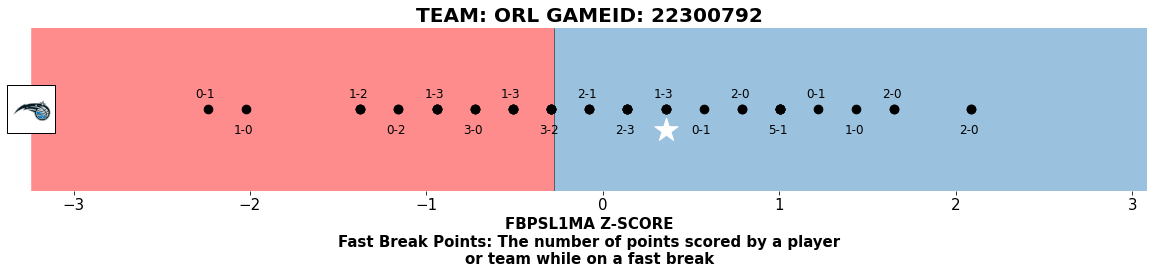

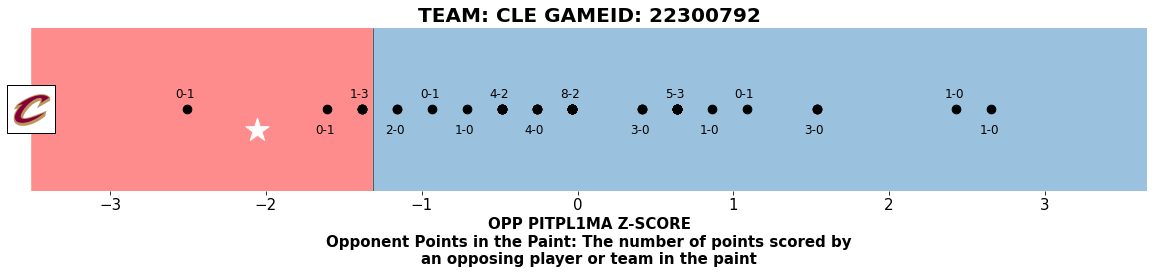

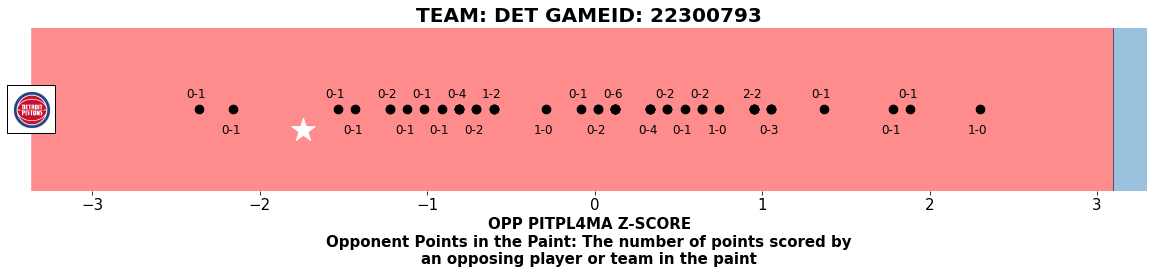

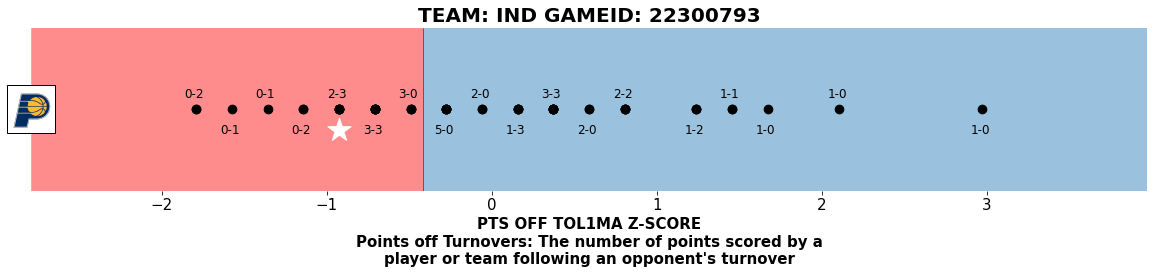

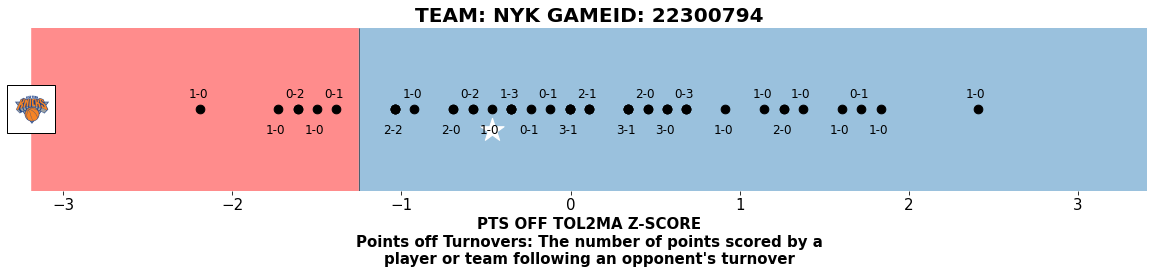

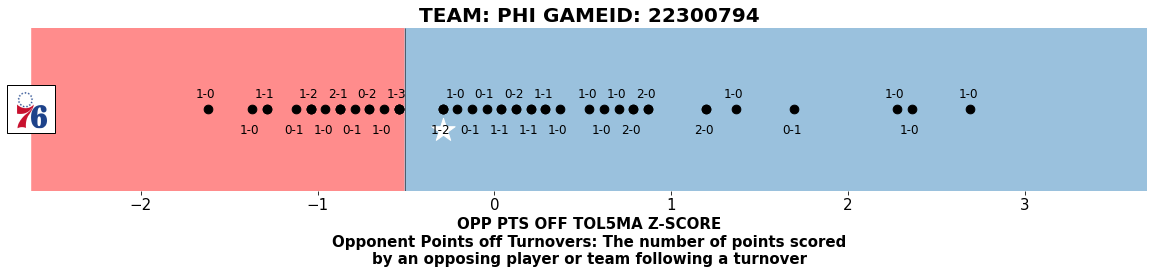

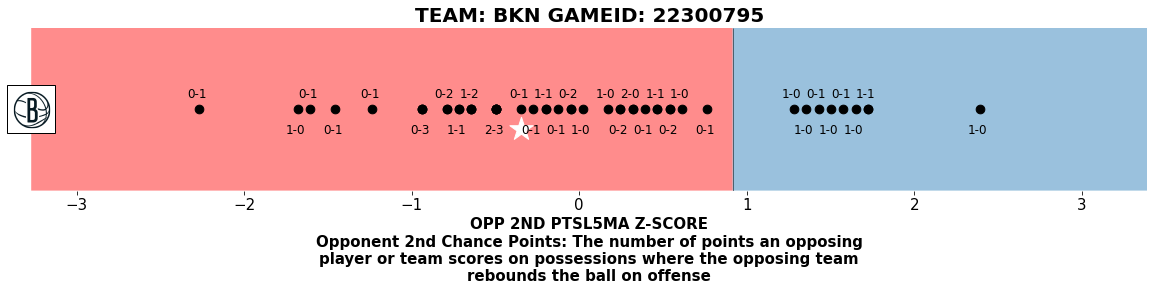

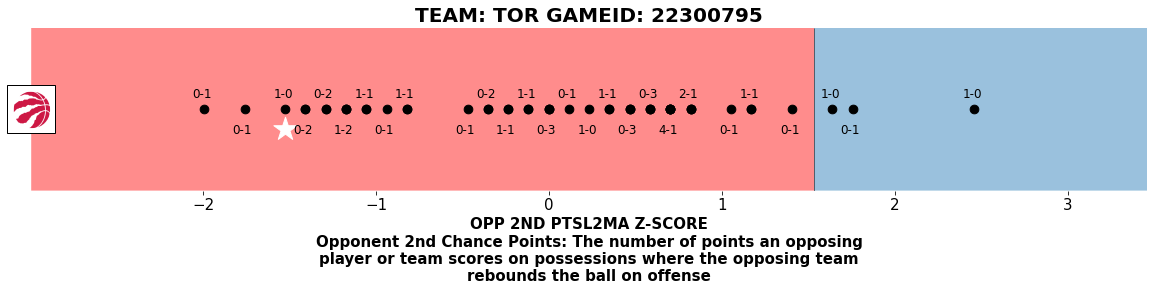

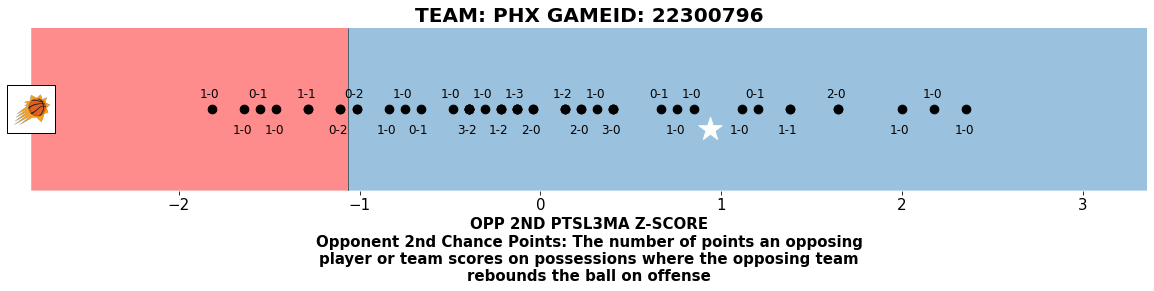

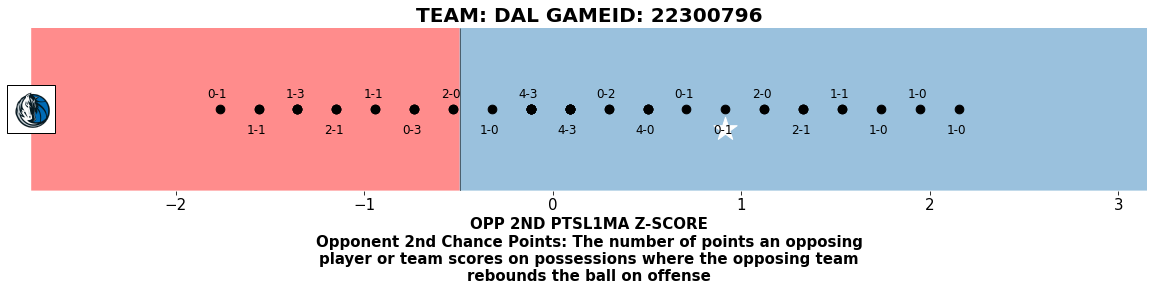

/Users/olutosinfashusi/opt/anaconda3/lib/python3.8/site-packages/mlxtend/plotting/decision_regions.py:243: UserWarning: No contour levels were found within the data range.
  ax.contour(xx, yy, Z, cset.levels,


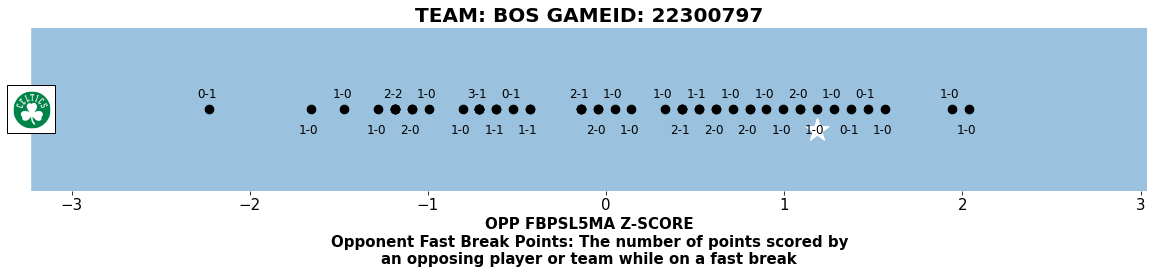

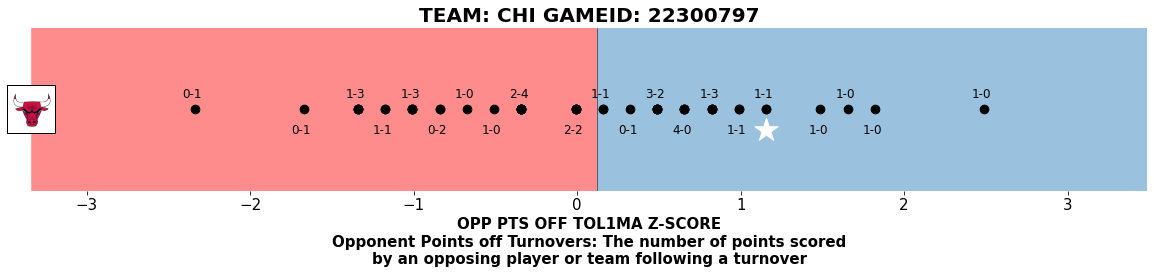

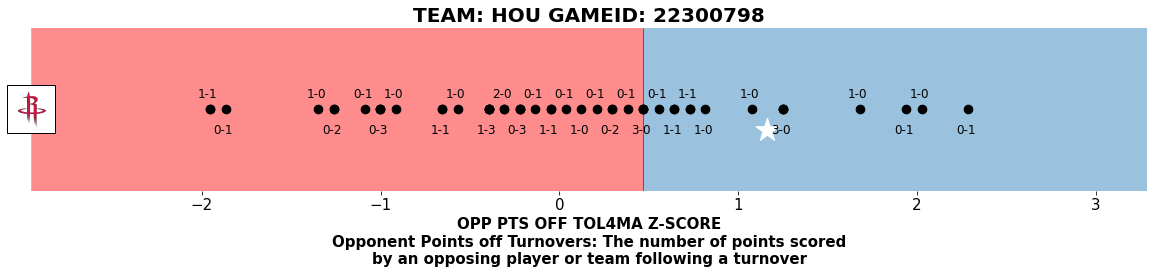

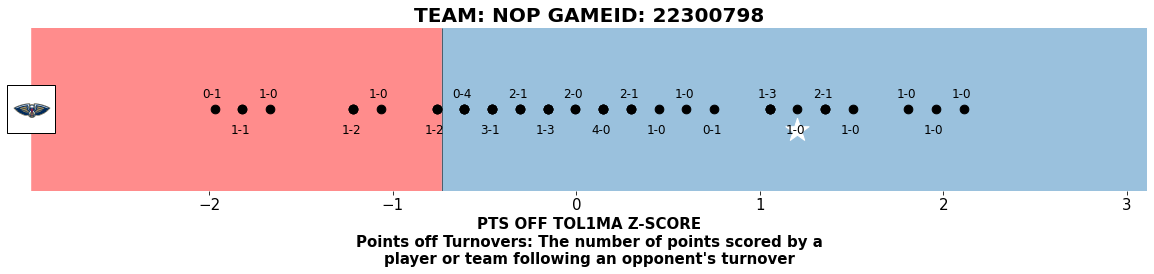

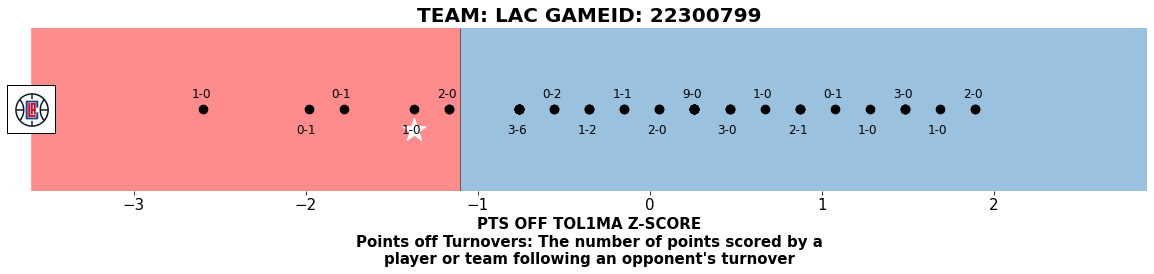

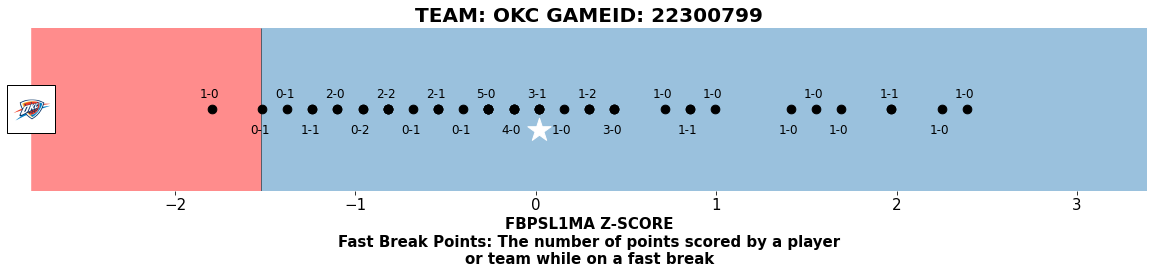

/Users/olutosinfashusi/opt/anaconda3/lib/python3.8/site-packages/mlxtend/plotting/decision_regions.py:243: UserWarning: No contour levels were found within the data range.
  ax.contour(xx, yy, Z, cset.levels,


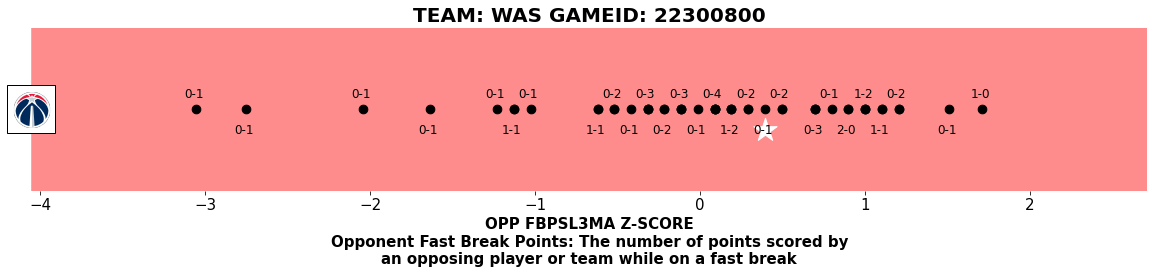

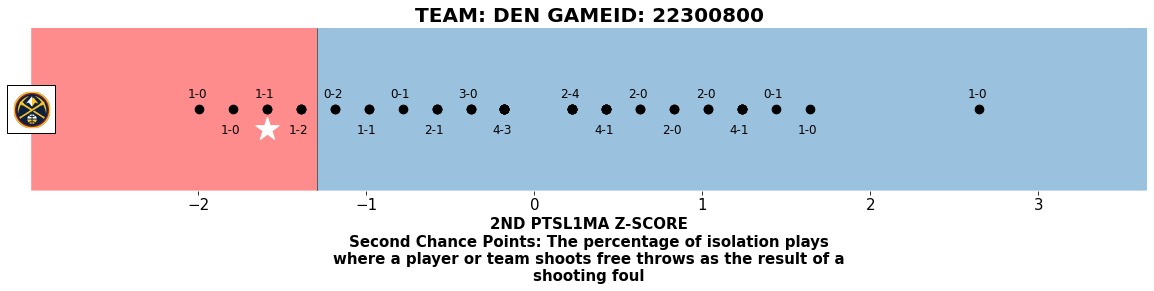

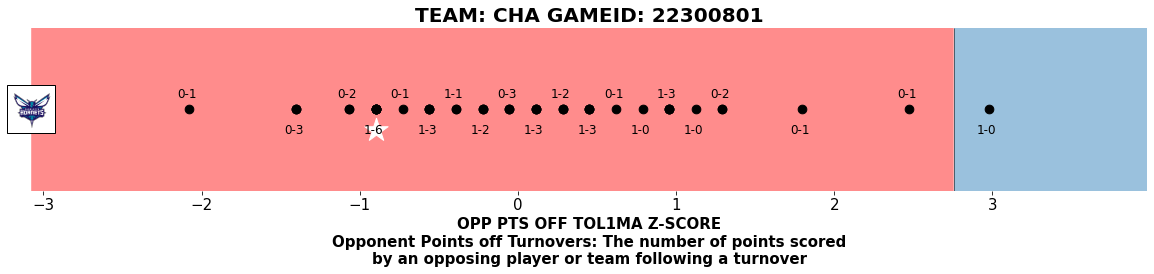

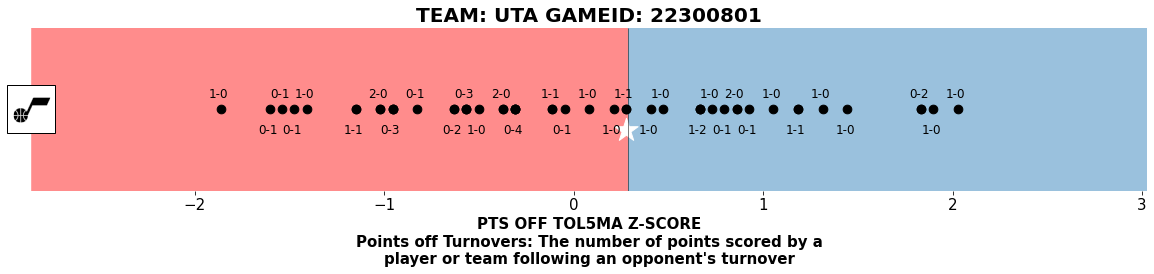

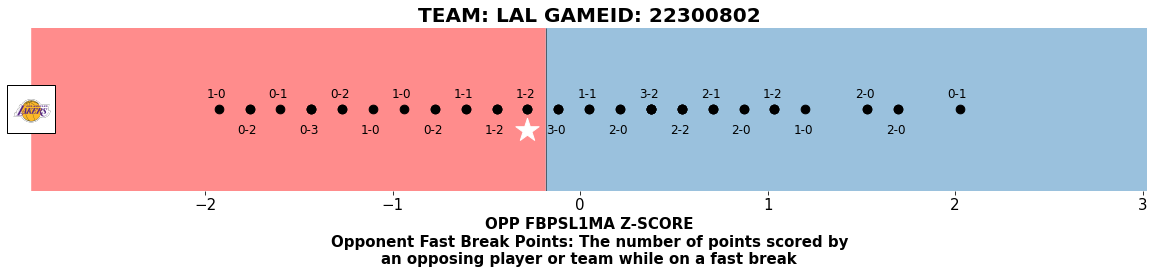

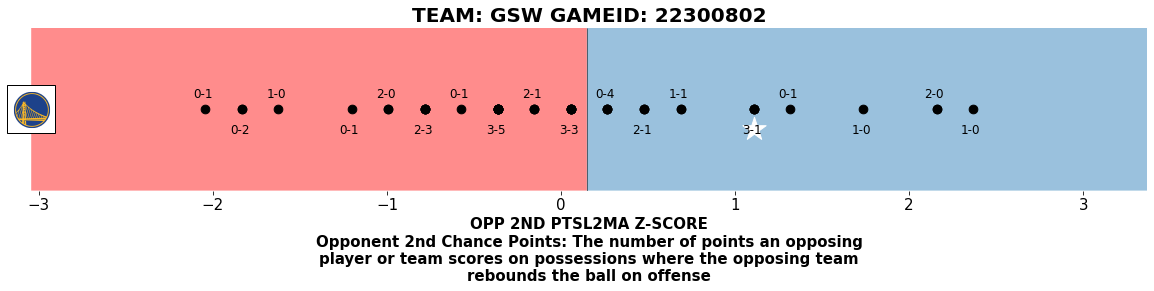

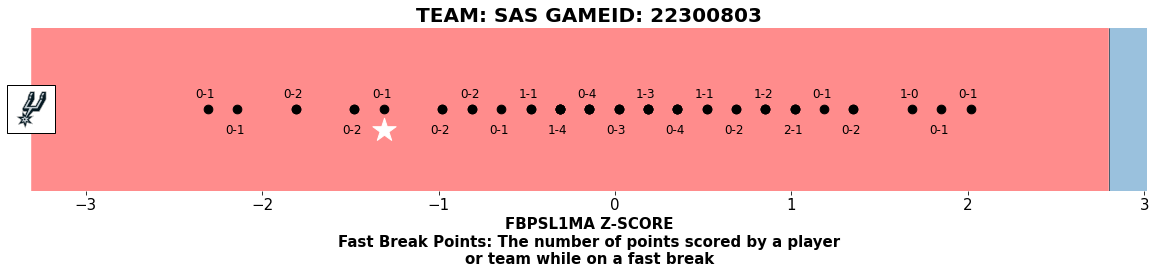

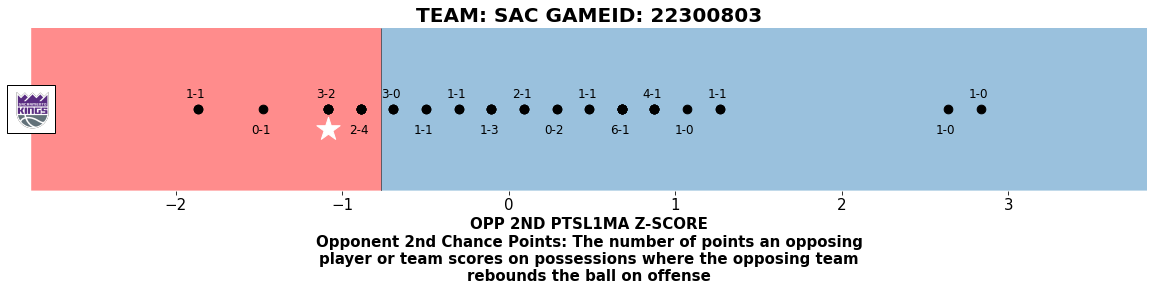

In [2164]:
for team in testDetailsDF['TEAM']:
    showStandardizedMactchPredictions(miscDF,testDetailsDF,team,datetime.date(2024,2,22),standardize=True)

In [2189]:
def getTestDetailsDF(modelTypeResults,rawOrStandardized,oddsRatioOrlogLoss):
    testDetailsDF = pd.DataFrame()
    return modelTypeResults[rawOrStandardized][oddsRatioOrlogLoss]['testDetailsDF']
def getFeaturesByTeam(NBAdf,modelTypeResults,rawOrStandardized,oddsRatioOrlogLoss):
    dateTestDetailsDF  = pd.DataFrame()
    dateOfNBAAllStarGame = datetime.date(2024,2,18)
    datesPostAllStarGame = np.unique(NBAdf[NBAdf['DATE'] > dateOfNBAAllStarGame]['DATE']).tolist()
    for date in datesPostAllStarGame:
        dateTestDetailsDF = pd.concat([dateTestDetailsDF ,
                                   modelTypeResults[date][rawOrStandardized][oddsRatioOrlogLoss]['testDetailsDF']],axis=0)
    leagueDF = pd.DataFrame()
    for team in np.unique(NBAdf['TEAM']):
        teamDF = pd.DataFrame(np.unique(dateTestDetailsDF [dateTestDetailsDF ['TEAM'] == team]['FEATURE'],return_counts=True)).T.rename(columns={0:'FEATURE',1:'COUNT'})
        teamDF = pd.concat([pd.DataFrame(np.full(len(teamDF),team),columns=['TEAM']),teamDF],axis=1).sort_values(by='COUNT',ascending=False)
        leagueDF = pd.concat([leagueDF,teamDF],axis=0)
    leagueDF = leagueDF.reset_index(drop=True)
    return leagueDF 
def featureByLeague(NBAdf,modelTypeResults,rawOrStandardized,oddsRatioOrlogLoss):
    testDetailsDF = pd.DataFrame()
    for date in datesPostAllStarGame:
        testDetailsDF = pd.concat([testDetailsDF,
                                   modelTypeResults[date][rawOrStandardized][oddsRatioOrlogLoss]['testDetailsDF']],axis=0)
    leagueDF = pd.DataFrame()
    for team in np.unique(NBAdf['TEAM']):
        teamDF = pd.DataFrame(np.unique(testDetailsDF[testDetailsDF['TEAM'] == team]['FEATURE'],return_counts=True)).T.rename(columns={0:'FEATURE',1:'COUNT'})
        teamDF = pd.concat([pd.DataFrame(np.full(len(teamDF),team),columns=['TEAM']),teamDF],axis=1).sort_values(by='COUNT',ascending=False)
        leagueDF = pd.concat([leagueDF,teamDF],axis=0)
    leagueDF = leagueDF.reset_index(drop=True)
    leagueDF = pd.DataFrame(np.unique(leagueDF['FEATURE'],return_counts=True)).T.rename(columns={0:'FEATURE',1:'COUNT'}).sort_values(by='COUNT',ascending=False).reset_index(drop=True)
    return leagueDF 
def getSeasonTestDetailsDF(NBAdf,modelTypeResults,rawOrStandardized,oddsRatioOrlogLoss):
    seasonTestDetailsDF  = pd.DataFrame()
    dateOfNBAAllStarGame = datetime.date(2024,2,18)
    datesPostAllStarGame = np.unique(NBAdf[NBAdf['DATE'] > dateOfNBAAllStarGame]['DATE']).tolist()
    for date in datesPostAllStarGame:
        seasonTestDetailsDF = pd.concat([seasonTestDetailsDF ,
                                   modelTypeResults[date][rawOrStandardized][oddsRatioOrlogLoss]['testDetailsDF']],axis=0)
    return seasonTestDetailsDF

In [2178]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.ticker as mtick 
from matplotlib.ticker import PercentFormatter 
def getImage(path, zoom=1): return OffsetImage(plt.imread(path), zoom=zoom)
paths = []
for team in NBATeams:
    paths.append('/Users/olutosinfashusi/jupyter/git/predict2023-24NBARegularSeasonGames_LogisticRegression/images/'+team+'.png')

# miscDF+standardizedOddsRatio, SEASONTestDetails

In [2192]:
# seasonTestDetailsDF = getSeasonTestDetailsDF(miscDF,miscTestDetails,'standardized','oddsRatio')
# seasonTestDetailsDF

In [2191]:
featuresByTeamDF = getFeaturesByTeam(miscDF,miscTestDetails,'standardized','oddsRatio')
featuresByTeamDF.sort_values(by=['COUNT','FEATURE'],ascending=False).reset_index(drop=True)
featuresByTeamDF

,TEAM,FEATURE,COUNT
0,ATL,2ND PTSL3MA,27
1,BKN,OPP 2ND PTSL5MA,23
2,BKN,OPP 2ND PTSL3MA,5
3,BOS,OPP 2ND PTSL2MA,8
4,BOS,2ND PTSL5MA,7
5,BOS,OPP FBPSL5MA,6
6,BOS,2ND PTSL1MA,5
7,BOS,FBPSL1MA,1
8,CHA,OPP PTS OFF TOL1MA,28
9,CHI,OPP PTS OFF TOL5MA,11


In [2193]:
total = []
for team in featuresByTeamDF['TEAM']:
    teamDF = featuresByTeamDF[featuresByTeamDF['TEAM'] == team]
    total.append(np.sum(teamDF['COUNT'].values))
featuresByTeamDF['TOTAL'] = total
featuresByTeamDF

,TEAM,FEATURE,COUNT,TOTAL
0,ATL,2ND PTSL3MA,27,27
1,BKN,OPP 2ND PTSL5MA,23,28
2,BKN,OPP 2ND PTSL3MA,5,28
3,BOS,OPP 2ND PTSL2MA,8,27
4,BOS,2ND PTSL5MA,7,27
5,BOS,OPP FBPSL5MA,6,27
6,BOS,2ND PTSL1MA,5,27
7,BOS,FBPSL1MA,1,27
8,CHA,OPP PTS OFF TOL1MA,28,28
9,CHI,OPP PTS OFF TOL5MA,11,27


In [1558]:
pd.DataFrame(np.unique(leagueFeaturesDF['FEATURE'],return_counts=True)).T.rename(columns={0:'FEATURE',1:'COUNT'}).sort_values(by='COUNT',ascending=False).head()

,FEATURE,COUNT
8,OPP 2ND PTSL1MA,7
5,FBPSL1MA,6
9,OPP 2ND PTSL2MA,6
0,2ND PTSL1MA,4
26,OPP PTS OFF TOL5MA,4


In [2238]:
sameFeatureDF = pd.DataFrame()
for i in range(len(featuresByTeamDF)):
    if featuresByTeamDF.iloc[i]['COUNT'] == featuresByTeamDF.iloc[i]['TOTAL']:
        sameFeatureDF = pd.concat([sameFeatureDF,
                                   featuresByTeamDF.iloc[i].to_frame().T],axis=0)
sameFeatureDF = sameFeatureDF.reset_index(drop=True)
sameFeatureDF

,TEAM,FEATURE,COUNT,TOTAL
0,ATL,2ND PTSL3MA,27,27
1,CHA,OPP PTS OFF TOL1MA,28,28
2,LAC,PTS OFF TOL1MA,29,29
3,MEM,FBPSL1MA,26,26
4,OKC,FBPSL1MA,28,28


In [2289]:
maxFeatureDF = pd.DataFrame()
total = []
defintions = []
string_ = []
for team in np.unique(miscDF['TEAM']):
    teamDF = featuresByTeamDF[featuresByTeamDF['TEAM'] == team]
    total.append(np.sum(teamDF['COUNT'].values))
    maxFeatureDF = pd.concat([maxFeatureDF,teamDF.head(1)],axis=0)
maxFeatureDF

,TEAM,FEATURE,COUNT,TOTAL
0,ATL,2ND PTSL3MA,27,27
1,BKN,OPP 2ND PTSL5MA,23,28
3,BOS,OPP 2ND PTSL2MA,8,27
8,CHA,OPP PTS OFF TOL1MA,28,28
9,CHI,OPP PTS OFF TOL5MA,11,27
14,CLE,OPP PITPL1MA,27,29
16,DAL,OPP 2ND PTSL1MA,21,27
18,DEN,OPP FBPSL4MA,24,27
21,DET,2ND PTSL2MA,9,28
26,GSW,OPP FBPSL1MA,17,29


In [2361]:
np.random.seed(24)
df = pd.DataFrame({'A': np.linspace(1, 10, 10)})

df = pd.concat([df, pd.DataFrame(np.random.randn(10, 4), columns=list('BCDE'))],
               axis=1)
df.iloc[0, 2] = np.nan
df

,A,B,C,D,E
0,1.0,1.329212,NaN,-0.316280,-0.990810
1,2.0,-1.070816,-1.438713,0.564417,0.295722
2,3.0,-1.626404,0.219565,0.678805,1.889273
3,4.0,0.961538,0.104011,-0.481165,0.850229
4,5.0,1.453425,1.057737,0.165562,0.515018
5,6.0,-1.336936,0.562861,1.392855,-0.063328
6,7.0,0.121668,1.207603,-0.002040,1.627796
7,8.0,0.354493,1.037528,-0.385684,0.519818
8,9.0,1.686583,-1.325963,1.428984,-2.089354
9,10.0,-0.129820,0.631523,-0.586538,0.290720


In [2363]:
def highlight_greaterthan(s, threshold, column):
    #print(s)
    is_max = pd.Series(data=False, index=s.index)
    is_max[column] = s.loc[column] >= threshold
    return ['background-color: yellow' if is_max.any() else '' for v in is_max]


df.style.apply(highlight_greaterthan, threshold=1.0, column=['C', 'B'], axis=1)

,A,B,C,D,E
0,1.000000,1.329212,nan,-0.316280,-0.990810
1,2.000000,-1.070816,-1.438713,0.564417,0.295722
2,3.000000,-1.626404,0.219565,0.678805,1.889273
3,4.000000,0.961538,0.104011,-0.481165,0.850229
4,5.000000,1.453425,1.057737,0.165562,0.515018
5,6.000000,-1.336936,0.562861,1.392855,-0.063328
6,7.000000,0.121668,1.207603,-0.002040,1.627796
7,8.000000,0.354493,1.037528,-0.385684,0.519818
8,9.000000,1.686583,-1.325963,1.428984,-2.089354
9,10.000000,-0.129820,0.631523,-0.586538,0.290720


In [2255]:
#maxFeatureDF

In [2252]:
# def highlightDF(element):
#     if element in list(sameFeatureDF['TEAM'].values):
#         return 'background-color: yellow'
# maxFeatureDF.style.apply(highlightDF,columns=['TEAM'])

In [2327]:
maxFeatureDF = pd.DataFrame()
total = []
defintions = []
string_ = []
for team in np.unique(miscDF['TEAM']):
    teamDF = featuresByTeamDF[featuresByTeamDF['TEAM'] == team]
    total.append(np.sum(teamDF['COUNT'].values))
    maxFeatureDF = pd.concat([maxFeatureDF,teamDF.head(1)],axis=0)
sameFeatureDF = pd.DataFrame()
for i in range(len(featuresByTeamDF)):
    if featuresByTeamDF.iloc[i]['COUNT'] == featuresByTeamDF.iloc[i]['TOTAL']:
        sameFeatureDF = pd.concat([sameFeatureDF,
                                   featuresByTeamDF.iloc[i].to_frame().T],axis=0)
sameFeatureDF = sameFeatureDF.reset_index(drop=True)

In [2328]:
# def highlight(row):
#     if row['TEAM'] in list(sameFeatureDF['TEAM'].values):
#         return ['background-color: yellow'] * len(row)
# maxFeatureDF.style.apply(highlight,axis=1)
# #df.style.apply(highlight_greaterthan, threshold=1.0, column=['C', 'B'], axis=1)

In [2464]:
maxFeatureDF = pd.DataFrame()
total = []
defintions = []
string_ = []
for team in np.unique(miscDF['TEAM']):
    teamDF = leagueFeaturesDF[leagueFeaturesDF['TEAM'] == team]
    total.append(np.sum(teamDF['COUNT'].values))
    
    maxFeatureDF = pd.concat([maxFeatureDF,teamDF.head(1)],axis=0)
    maxFeatureDF = maxFeatureDF.reset_index(drop=True)
    defintions.append(getFeatureDefintion(teamDF['FEATURE'].values[0]))
    string_.append(str(teamDF['COUNT'].values[0]) +'/'+str(total[-1]))

maxFeatureDF['FREQUENCY'] = string_
maxFeatureDF['FEATURE DEFINTION'] =  defintions
def highlight(row):
    rowsToHighlight = list(sameFeatureDF['TEAM'].values)
    if row['TEAM'] in rowsToHighlight:
        return ['background-color: yellow'] * len(row)
    else: return ['background-color: white'] * len(row)
maxFeatureDF.style.apply(highlight,axis=1)

,TEAM,FEATURE,COUNT,FREQUENCY,FEATURE DEFINTION
0,ATL,2ND PTSL3MA,27,27/27,Second Chance Points: The percentage of isolation plays where a player or team shoots free throws as the result of a shooting foul
1,BKN,OPP 2ND PTSL5MA,23,23/28,Opponent 2nd Chance Points: The number of points an opposing player or team scores on possessions where the opposing team rebounds the ball on offense
2,BOS,OPP 2ND PTSL2MA,8,8/27,Opponent 2nd Chance Points: The number of points an opposing player or team scores on possessions where the opposing team rebounds the ball on offense
3,CHA,OPP PTS OFF TOL1MA,28,28/28,Opponent Points off Turnovers: The number of points scored by an opposing player or team following a turnover
4,CHI,OPP PTS OFF TOL5MA,11,11/27,Opponent Points off Turnovers: The number of points scored by an opposing player or team following a turnover
5,CLE,OPP PITPL1MA,27,27/29,Opponent Points in the Paint: The number of points scored by an opposing player or team in the paint
6,DAL,OPP 2ND PTSL1MA,21,21/27,Opponent 2nd Chance Points: The number of points an opposing player or team scores on possessions where the opposing team rebounds the ball on offense
7,DEN,OPP FBPSL4MA,24,24/27,Opponent Fast Break Points: The number of points scored by an opposing player or team while on a fast break
8,DET,2ND PTSL2MA,9,9/28,Second Chance Points: The percentage of isolation plays where a player or team shoots free throws as the result of a shooting foul
9,GSW,OPP FBPSL1MA,17,17/29,Opponent Fast Break Points: The number of points scored by an opposing player or team while on a fast break


In [2597]:
feature = '2ND PTSL3MA'
results = {}
for team in NBATeams:
    results[team] = {'2ND PTSL3MA AVG IN Ws':float,'2ND PTSL3MA AVG IN Ls':float}
for team in NBATeams:
    teamDF = miscDF[miscDF['TEAM'] == team]
    results[team]['2ND PTSL3MA AVG IN Ws'] = teamDF[teamDF['RESULT'] == 1][feature].mean()
    results[team]['2ND PTSL3MA AVG IN Ls'] = teamDF[teamDF['RESULT'] == 0][feature].mean()
df = pd.DataFrame(results).T
df['∆'] = df['2ND PTSL3MA AVG IN Ws'] - df['2ND PTSL3MA AVG IN Ls']

df.sort_values(by='∆',ascending=False)
df = df.reset_index()
df = df.rename(columns={'index':'TEAM'})
df = df.sort_values(by='∆',ascending=False).reset_index(drop=True)
def highlight(row):
    rowsToHighlight = ['ATL']
    if row['TEAM'] in rowsToHighlight:
        return ['background-color: yellow'] * len(row)
    else: return ['background-color: white'] * len(row)
df.style.apply(highlight,axis=1)

,TEAM,2ND PTSL3MA AVG IN Ws,2ND PTSL3MA AVG IN Ls,∆
0,ATL,17.552381,14.750000,2.802381
1,MIL,13.645390,12.552083,1.093307
2,CLE,13.950355,12.864583,1.085771
3,POR,16.412698,15.522989,0.889710
4,SAC,14.848485,14.257143,0.591342
5,MIA,11.585185,11.078431,0.506754
6,BOS,14.655738,14.203704,0.452034
7,CHI,13.780702,13.463415,0.317287
8,MIN,13.515152,13.236111,0.279040
9,DET,13.277778,13.049751,0.228027


In [2475]:
feature = 'OPP PTS OFF TOL1MA'
results = {}
for team in NBATeams:
    results[team] = {'OPP PTS OFF TOL1MA AVG IN Ws':float ,'OPP PTS OFF TOL1MA AVG IN Ls':float}
for team in NBATeams:
    teamDF = miscDF[miscDF['TEAM'] == team]
    results[team]['OPP PTS OFF TOL1MA AVG IN Ws'] = teamDF[teamDF['RESULT'] == 1][feature].mean()
    results[team]['OPP PTS OFF TOL1MA AVG IN Ls'] = teamDF[teamDF['RESULT'] == 0][feature].mean()
df = pd.DataFrame(results).T
df['∆'] = df['OPP PTS OFF TOL1MA AVG IN Ws'] - df['OPP PTS OFF TOL1MA AVG IN Ls']
df.sort_values(by='∆',ascending=False)
df = df.reset_index()
df = df.rename(columns={'index':'TEAM'})
df = df.sort_values(by='∆',ascending=False).reset_index(drop=True)
def highlight(row):
    rowsToHighlight = ['CHA']
    if row['TEAM'] in rowsToHighlight:
        return ['background-color: yellow'] * len(row)
    else: return ['background-color: white'] * len(row)
df.style.apply(highlight,axis=1)

,TEAM,OPP PTS OFF TOL1MA AVG IN Ws,OPP PTS OFF TOL1MA AVG IN Ls,∆
0,DET,22.500000,19.029851,3.470149
1,ORL,17.565217,15.114286,2.450932
2,SAS,20.363636,18.050847,2.312789
3,CHA,18.900000,16.590164,2.309836
4,GSW,18.217391,16.171429,2.045963
5,PHI,15.021277,13.382353,1.638924
6,WAS,18.000000,16.803030,1.196970
7,CHI,15.871795,14.738095,1.133700
8,MIN,16.410714,15.320000,1.090714
9,BKN,15.906250,15.122449,0.783801


In [2478]:
feature = 'PTS OFF TOL1MA'
results = {}
for team in NBATeams:
    results[team] = {'PTS OFF TOL1MA AVG IN Ws':float ,'PTS OFF TOL1MA AVG IN Ls':float}
for team in NBATeams:
    teamDF = miscDF[miscDF['TEAM'] == team]
    results[team]['PTS OFF TOL1MA AVG IN Ws'] = teamDF[teamDF['RESULT'] == 1][feature].mean()
    results[team]['PTS OFF TOL1MA AVG IN Ls'] = teamDF[teamDF['RESULT'] == 0][feature].mean()
df = pd.DataFrame(results).T
df['∆'] = df['PTS OFF TOL1MA AVG IN Ws'] - df['PTS OFF TOL1MA AVG IN Ls']

df.sort_values(by='∆',ascending=False)
df = df.reset_index()
df = df.rename(columns={'index':'TEAM'})
df = df.sort_values(by='∆',ascending=False).reset_index(drop=True)
def highlight(row):
    rowsToHighlight = ['LAC']
    if row['TEAM'] in rowsToHighlight:
        return ['background-color: yellow'] * len(row)
    else: return ['background-color: white'] * len(row)
df.style.apply(highlight,axis=1)

,TEAM,PTS OFF TOL1MA AVG IN Ws,PTS OFF TOL1MA AVG IN Ls,∆
0,LAC,17.260000,14.354839,2.905161
1,ORL,19.434783,17.314286,2.120497
2,NOP,18.500000,16.454545,2.045455
3,DAL,17.224490,15.312500,1.911990
4,CHI,18.076923,16.309524,1.767399
5,PHI,18.340426,17.058824,1.281602
6,IND,18.065217,16.971429,1.093789
7,SAS,15.772727,15.118644,0.654083
8,DEN,15.732143,15.080000,0.652143
9,ATL,17.444444,16.911111,0.533333


In [2479]:
feature = 'FBPSL1MA'
results = {}
for team in NBATeams:
    results[team] = {'FBPSL1MA AVG IN Ws':float ,'FBPSL1MA AVG IN Ls':float}
for team in NBATeams:
    teamDF = miscDF[miscDF['TEAM'] == team]
    results[team]['FBPSL1MA AVG IN Ws'] = teamDF[teamDF['RESULT'] == 1][feature].mean()
    results[team]['FBPSL1MA AVG IN Ls'] = teamDF[teamDF['RESULT'] == 0][feature].mean()
df = pd.DataFrame(results).T
df['∆'] = df['FBPSL1MA AVG IN Ws'] - df['FBPSL1MA AVG IN Ls']

df.sort_values(by='∆',ascending=False)
df = df.reset_index()
df = df.rename(columns={'index':'TEAM'})
df = df.sort_values(by='∆',ascending=False).reset_index(drop=True)
def highlight(row):
    rowsToHighlight = ['OKC','MEM']
    if row['TEAM'] in rowsToHighlight:
        return ['background-color: yellow'] * len(row)
    else: return ['background-color: white'] * len(row)
df.style.apply(highlight,axis=1)

,TEAM,FBPSL1MA AVG IN Ws,FBPSL1MA AVG IN Ls,∆
0,OKC,16.625000,13.920000,2.705000
1,ORL,13.282609,10.971429,2.311180
2,SAS,17.090909,14.881356,2.209553
3,MEM,12.962963,11.018519,1.944444
4,HOU,16.658537,14.825000,1.833537
5,DEN,14.589286,13.400000,1.189286
6,GSW,12.869565,11.742857,1.126708
7,CHI,12.974359,11.952381,1.021978
8,TOR,19.500000,18.508772,0.991228
9,CLE,15.170213,14.264706,0.905507


In [225]:
#defintions
def printFeatureDefintion(feature):
    import textwrap
    subStringsToRemove = ['L1MA','L2MA','L3MA','L4MA','L5MA']
    for subString in subStringsToRemove:
        feature = feature.replace(subString, '')
    definiton = glossaryDict[feature]['Name']+': '+glossaryDict[feature]['Definition']
    return textwrap.fill(definiton,80)
def getFeatureDefintion(feature):
    subStringsToRemove = ['L1MA','L2MA','L3MA','L4MA','L5MA']
    for subString in subStringsToRemove:
        feature = feature.replace(subString, '')
    definiton = glossaryDict[feature]['Name']+': '+glossaryDict[feature]['Definition']
    return definiton

# ODDS RATIO PROFF

In [2724]:
def proveFeatureSelections(NBAdf,team,features,date,standardize,sortBy):
    resultsDict = {}
    resultsDict[team] = {'DATE':[],'TEAM':[],'TRAIN SIZE':[],'FEATURE':[],'INTERCEPT':[],
                         'COEF':[],'ODDS RATIO':[],'LOG LOSS':[],'STD':[]}
    for feature in features:
        NBAtrain = NBAdf[NBAdf['DATE'] < date].dropna()
        NBAtest = NBAdf[NBAdf['DATE'] == date].reset_index(drop=True)
        X_train = NBAtrain[NBAtrain['TEAM'] == team][feature]
        X_train = np.array(X_train)
        X_train = np.reshape(X_train,(len(X_train),1))
        if (standardize): X_train = StandardScaler().fit_transform(X_train)
        y_train = NBAtrain[NBAtrain['TEAM'] == team]['RESULT']
        model = LogisticRegression(random_state=0)
        model.fit(X_train,y_train)
        model = model.fit(X_train,y_train)
        resultsDict[team]['DATE'].append(date),
        resultsDict[team]['TEAM'].append(team)
        resultsDict[team]['TRAIN SIZE'].append(len(X_train))
        resultsDict[team]['FEATURE'].append(feature),
        resultsDict[team]['INTERCEPT'].append(model.intercept_[0])
        resultsDict[team]['COEF'].append(model.coef_[0][0])
        resultsDict[team]['ODDS RATIO'].append(np.exp(model.coef_[0][0]))
        resultsDict[team]['LOG LOSS'].append(log_loss(y_train, model.predict_proba(X_train)))
        resultsDict[team]['STD'].append(np.std(X_train))
    if sortBy == 'ODDS RATIO':
        return pd.DataFrame(resultsDict[team]).sort_values(by='ODDS RATIO',ascending=False).reset_index(drop=True)
    if sortBy == 'LOG LOSS':
        return pd.DataFrame(resultsDict[team]).sort_values(by='LOG LOSS',ascending=True).reset_index(drop=True)

In [2796]:
ORL_byOddsRatioTrue = proveFeatureSelections(miscDF,'ORL',miscFeatures,datetime.date(2024, 2, 22),standardize=False,sortBy='ODDS RATIO')
ORL_byOddsRatioStandardized = proveFeatureSelections(miscDF,'ORL',miscFeatures,datetime.date(2024, 2, 22),standardize=True,sortBy='ODDS RATIO')
ORL_byLogLossTrue = proveFeatureSelections(miscDF,'ORL',miscFeatures,datetime.date(2024, 2, 22),standardize=False,sortBy='LOG LOSS')
ORL_byLogLossStandardized = proveFeatureSelections(miscDF,'ORL',miscFeatures,datetime.date(2024, 2, 22),standardize=True,sortBy='LOG LOSS')

In [2605]:
# plotLeft():
#     fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(12,6))
#     ax0,ax1 = axes.flatten()
#     maxCorr = []
#     minCorr = []
#     colors = ['blue','purple','green','darkgrey','red']
#     features = CLE_byOddsRatioRaw.head()['feature'].values
#     colorsIter = 0
#     for feature in ORL_byOddsRatioRaw.head()['feature']:
#         proffDF = buildFeatureDF(miscDF,'ORL',datetime.date(2024, 2, 22),feature).sort_values(by=feature)
#         minCorr.append((proffDF.head(1)[feature].values[0],proffDF.head(1)['HYPO'].values[0]))
#         maxCorr.append((proffDF.tail(1)[feature].values[0],proffDF.tail(1)['HYPO'].values[0]))
#         ax0.scatter(proffDF[feature],proffDF['HYPO'],c=colors[colorsIter]);
#         colorsIter = colorsIter+1
# plotRight():
    

In [2798]:
print(ORL_byOddsRatioTrue.head()['FEATURE'].values)
print(minCorr)
print(maxCorr)

['FBPSL1MA' 'PTS OFF TOL5MA' 'PTS OFF TOL3MA' 'OPP FBPSL5MA'
 'PTS OFF TOL2MA']
[(10.333333333333334, 0.4839425174241239), (9.0, 0.4943453820425423), (9.25, 0.5224997456667264), (7.333333333333333, 0.506510209158704), (24.0, 0.23791463043746963)]
[(23.0, 0.8593665438998432), (22.2, 0.8625155222513209), (24.0, 0.8880405513586399), (24.333333333333332, 0.8613045089428345), (70.0, 0.966125769804386)]


In [2806]:
def highlight(row):
    rowsToHighlight  = list(ORL_byOddsRatioTrue.head().index.values) + list(ORL_byOddsRatioTrue.tail().index.values)
    if row.name in rowsToHighlight:
        return ['background-color: yellow'] * len(row)
    else: return ['background-color: white'] * len(row)
ORL_byOddsRatioTrue.style.apply(highlight,axis=1)

,DATE,TEAM,TRAIN SIZE,FEATURE,INTERCEPT,COEF,ODDS RATIO,LOG LOSS,STD
0,2024-02-22,ORL,50,FBPSL1MA,-1.877551,0.154112,1.166621,0.635021,4.624976
1,2024-02-22,ORL,50,PTS OFF TOL5MA,-2.643336,0.149497,1.161250,0.677058,2.143362
2,2024-02-22,ORL,50,PTS OFF TOL3MA,-1.676576,0.098302,1.103296,0.676977,3.310831
3,2024-02-22,ORL,50,OPP FBPSL5MA,-1.082496,0.087586,1.091536,0.680087,3.225402
4,2024-02-22,ORL,50,PTS OFF TOL2MA,-1.306061,0.078917,1.082115,0.675812,4.311392
5,2024-02-22,ORL,50,FBPSL5MA,-0.811459,0.072609,1.075310,0.687203,2.011364
6,2024-02-22,ORL,50,FBPSL4MA,-0.804980,0.071949,1.074601,0.686739,2.201727
7,2024-02-22,ORL,50,OPP PTS OFF TOL1MA,-0.959280,0.068191,1.070569,0.667515,6.391275
8,2024-02-22,ORL,50,OPP FBPSL2MA,-0.686521,0.059335,1.061131,0.679132,5.023385
9,2024-02-22,ORL,50,OPP PTS OFF TOL2MA,-0.791878,0.057469,1.059152,0.681903,4.453414


In [2805]:
ORL_byOddsRatioStandardized
def highlight(row):
    rowsToHighlight  = list(ORL_byOddsRatioStandardized.head().index.values) + list(ORL_byOddsRatioStandardized.tail().index.values)
    if row.name in rowsToHighlight:
        return ['background-color: yellow'] * len(row)
    else: return ['background-color: white'] * len(row)
ORL_byOddsRatioStandardized.style.apply(highlight,axis=1)

,DATE,TEAM,TRAIN SIZE,FEATURE,INTERCEPT,COEF,ODDS RATIO,LOG LOSS,STD
0,2024-02-22,ORL,50,FBPSL1MA,0.177765,0.648151,1.912002,0.635458,1.000000
1,2024-02-22,ORL,50,OPP PTS OFF TOL1MA,0.167306,0.401100,1.493466,0.667657,1.000000
2,2024-02-22,ORL,50,PTS OFF TOL2MA,0.163675,0.315113,1.370414,0.675896,1.000000
3,2024-02-22,ORL,50,PTS OFF TOL3MA,0.163247,0.302232,1.352875,0.677054,1.000000
4,2024-02-22,ORL,50,PTS OFF TOL5MA,0.163781,0.300912,1.351090,0.677131,1.000000
5,2024-02-22,ORL,50,PITPL1MA,0.163250,0.288498,1.334422,0.678184,1.000000
6,2024-02-22,ORL,50,OPP FBPSL2MA,0.163745,0.275756,1.317526,0.679196,1.000000
7,2024-02-22,ORL,50,OPP FBPSL5MA,0.163222,0.262774,1.300532,0.680144,1.000000
8,2024-02-22,ORL,50,OPP FBPSL1MA,0.163769,0.262657,1.300380,0.680250,1.000000
9,2024-02-22,ORL,50,OPP PITPL1MA,0.162885,0.254054,1.289241,0.680768,1.000000


In [2594]:
#https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.tick_params.html

In [2801]:
#testDetailsDF.insert(list(testDetailsDF.columns).index('TRUE X_test'),'TRUE X_test1',ans)

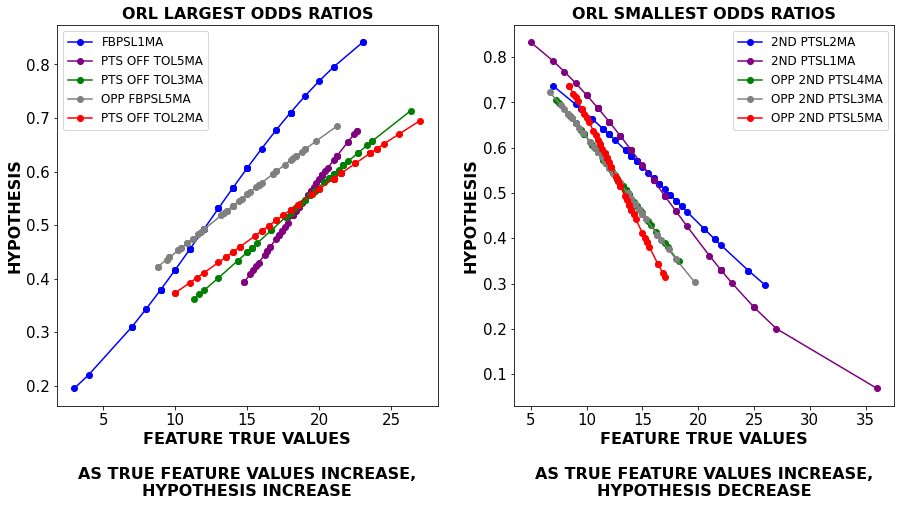

In [2803]:
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(15,7))
ax0,ax1 = axes.flatten()
colors = ['blue','purple','green','grey','red']
largestOddsRatioFeatures = ORL_byOddsRatioTrue.head()['FEATURE'].values
for feature in largestOddsRatioFeatures:
    proffDF = buildFeatureDF(miscDF,'ORL',datetime.date(2024, 2, 22),feature).sort_values(by=feature)
    ax0.plot(proffDF[feature],proffDF['HYPO'],
             c=colors[list(largestOddsRatioFeatures).index(feature)],
             label=feature,
             marker='o');

ax0.tick_params(labelsize=15)
ax0.set_title('ORL LARGEST ODDS RATIOS',size=16,fontweight ='bold')
ax0.set_ylabel('HYPOTHESIS',size=16,fontweight ='bold');

xLabelText = 'AS TRUE FEATURE VALUES INCREASE, HYPOTHESIS INCREASE'
xLabelText = textwrap.fill(xLabelText,35)
ax0.set_xlabel('FEATURE TRUE VALUES'+'\n\n'+xLabelText,size=16,fontweight ='bold');
ax0.legend(loc="upper left",prop={'size':12})

smallestOddsRatioFeatures = ORL_byOddsRatioTrue.tail()['FEATURE'].values
for feature in smallestOddsRatioFeatures:
    proffDF = buildFeatureDF(miscDF,'ORL',datetime.date(2024, 2, 22),feature).sort_values(by=feature)
    ax1.plot(proffDF[feature],proffDF['HYPO'],
             c=colors[list(smallestOddsRatioFeatures).index(feature)],
             marker='o',label=feature);
    colorsIter = colorsIter+1

ax1.tick_params(labelsize=15)
ax1.set_title('ORL SMALLEST ODDS RATIOS',size=16,fontweight ='bold')
ax1.set_ylabel('HYPOTHESIS',size=16,fontweight ='bold');

xLabelText = 'AS TRUE FEATURE VALUES INCREASE, HYPOTHESIS DECREASE'
xLabelText = textwrap.fill(xLabelText,35)
ax1.set_xlabel('FEATURE TRUE VALUES'+'\n\n'+xLabelText,size=16,fontweight ='bold');
ax1.legend(loc="upper right",prop={'size':12})

plt.show()

# STANDARDIZED FEATURE VALUES

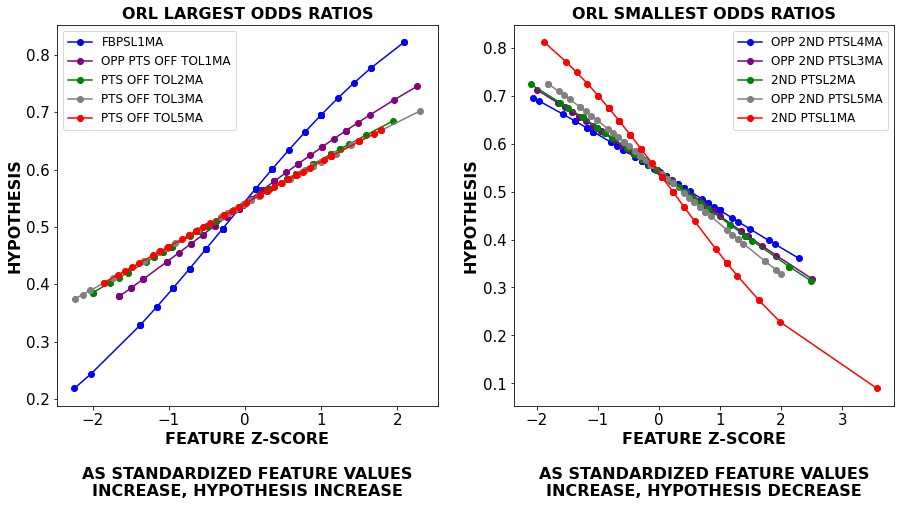

In [2804]:
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(15,7))
ax0,ax1 = axes.flatten()
colors = ['blue','purple','green','grey','red']
largestOddsRatioFeatures = ORL_byOddsRatioStandardized.head()['FEATURE'].values
for feature in largestOddsRatioFeatures:
    proffDF = buildFeatureDF(miscDF,'ORL',datetime.date(2024, 2, 22),feature).sort_values(by=feature)
    ax0.plot(proffDF['SS'+feature],proffDF['SSHYPO'],
             c=colors[list(largestOddsRatioFeatures).index(feature)],
             label=feature,
             marker='o');
ax0.tick_params(labelsize=15)
ax0.set_title('ORL LARGEST ODDS RATIOS',size=16,fontweight ='bold')
ax0.set_ylabel('HYPOTHESIS',size=16,fontweight ='bold');
ax0.legend(loc="upper left",prop={'size':12})

xLabelText = 'AS STANDARDIZED FEATURE VALUES INCREASE, HYPOTHESIS INCREASE'
xLabelText = textwrap.fill(xLabelText,35)
ax0.set_xlabel('FEATURE Z-SCORE'+'\n\n'+xLabelText,size=16,fontweight ='bold');



smallestOddsRatioFeatures = ORL_byOddsRatioStandardized.tail()['FEATURE'].values
for feature in smallestOddsRatioFeatures:
    proffDF = buildFeatureDF(miscDF,'ORL',datetime.date(2024, 2, 22),feature).sort_values(by=feature)
    ax1.plot(proffDF['SS'+feature],proffDF['SSHYPO'],
             c=colors[list(smallestOddsRatioFeatures).index(feature)],
             marker='o',label=feature);
    colorsIter = colorsIter+1
ax1.tick_params(labelsize=15)
ax1.set_title('ORL SMALLEST ODDS RATIOS',size=16,fontweight ='bold')
ax1.set_ylabel('HYPOTHESIS',size=16,fontweight ='bold');
ax1.legend(loc="upper right",prop={'size':12})

xLabelText = 'AS STANDARDIZED FEATURE VALUES INCREASE, HYPOTHESIS DECREASE'
xLabelText = textwrap.fill(xLabelText,35)
ax1.set_xlabel('FEATURE Z-SCORE'+'\n\n'+xLabelText,size=16,fontweight ='bold');

plt.show()

In [2844]:
# def highlight(row):
#     rowsToHighlight  = list(ORL_byLogLossTrue.head().index.values) + list(ORL_byLogLossTrue.tail().index.values)
#     if row.name in rowsToHighlight:
#         return ['background-color: yellow'] * len(row)
#     else: return ['background-color: white'] * len(row)
# ORL_byLogLossTrue.style.apply(highlight,axis=1)

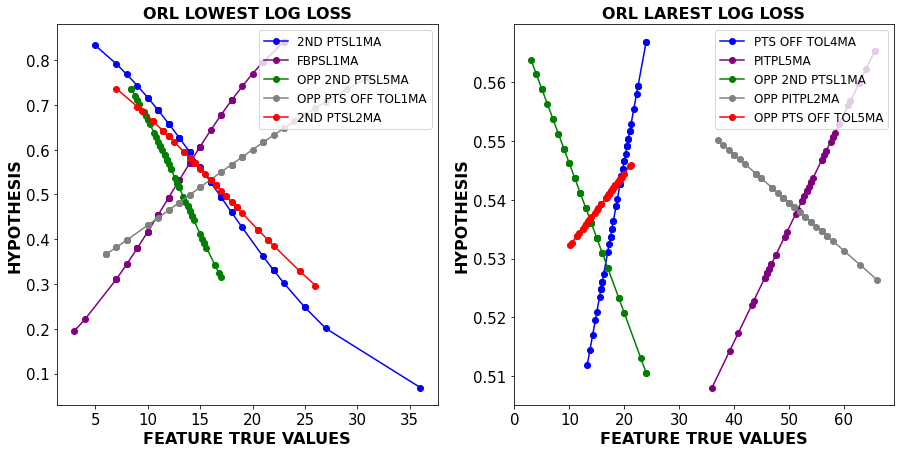

In [2843]:
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(15,7))
ax0,ax1 = axes.flatten()
colors = ['blue','purple','green','grey','red']
lowestLogLossFeatures = ORL_byLogLossTrue.head()['FEATURE'].values
for feature in lowestLogLossFeatures:
    proffDF = buildFeatureDF(miscDF,'ORL',datetime.date(2024, 2, 22),feature).sort_values(by=feature)
    ax0.plot(proffDF[feature],proffDF['HYPO'],
             c=colors[list(lowestLogLossFeatures).index(feature)],
             label=feature,
             marker='o');
ax0.tick_params(labelsize=15)
ax0.set_title('ORL LOWEST LOG LOSS',size=16,fontweight ='bold')
ax0.set_ylabel('HYPOTHESIS',size=16,fontweight ='bold');
ax0.set_xlabel('FEATURE TRUE VALUES',size=16,fontweight ='bold');
ax0.legend(loc="upper right",prop={'size':12})
largestLogLossFeatures = ORL_byLogLossTrue.tail()['FEATURE'].values
for feature in largestLogLossFeatures:
    proffDF = buildFeatureDF(miscDF,'ORL',datetime.date(2024, 2, 22),feature).sort_values(by=feature)
    ax1.plot(proffDF[feature],proffDF['HYPO'],
             c=colors[list(largestLogLossFeatures).index(feature)],
             label=feature,
             marker='o');
ax1.tick_params(labelsize=15)
ax1.set_title('ORL LAREST LOG LOSS',size=16,fontweight ='bold')
ax1.set_ylabel('HYPOTHESIS',size=16,fontweight ='bold');
ax1.set_xlabel('FEATURE TRUE VALUES',size=16,fontweight ='bold');
ax1.legend(loc="upper right",prop={'size':12})
plt.show()

In [2846]:
# def highlight(row):
#     rowsToHighlight  = list(ORL_byLogLossStandardized.head().index.values) + list(ORL_byLogLossStandardized.tail().index.values)
#     if row.name in rowsToHighlight:
#         return ['background-color: yellow'] * len(row)
#     else: return ['background-color: white'] * len(row)
# ORL_byLogLossStandardized.style.apply(highlight,axis=1)

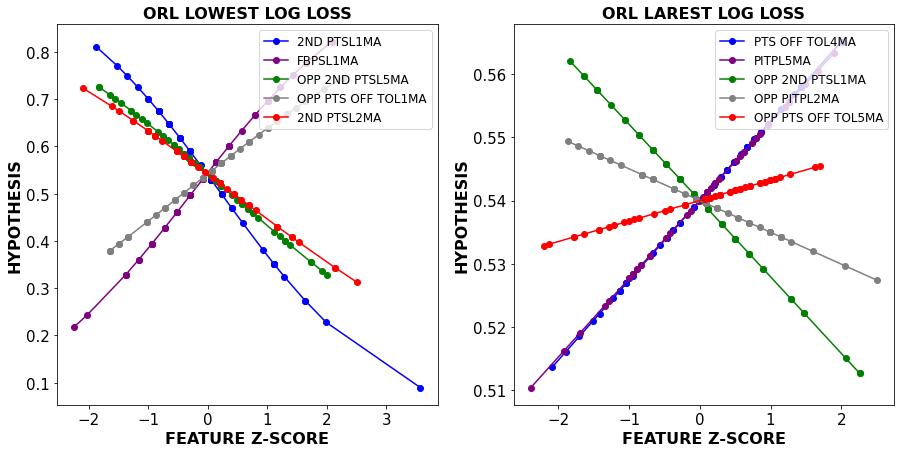

In [2847]:
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(15,7))
ax0,ax1 = axes.flatten()
colors = ['blue','purple','green','grey','red']
lowestLogLossFeatures = ORL_byLogLossStandardized.head()['FEATURE'].values
for feature in lowestLogLossFeatures:
    proffDF = buildFeatureDF(miscDF,'ORL',datetime.date(2024, 2, 22),feature).sort_values(by=feature)
    ax0.plot(proffDF['SS'+feature],proffDF['SSHYPO'],
             c=colors[list(lowestLogLossFeatures).index(feature)],
             label=feature,
             marker='o');
ax0.tick_params(labelsize=15)
ax0.set_title('ORL LOWEST LOG LOSS',size=16,fontweight ='bold')
ax0.set_ylabel('HYPOTHESIS',size=16,fontweight ='bold');
ax0.set_xlabel('FEATURE Z-SCORE',size=16,fontweight ='bold');
ax0.legend(loc="upper right",prop={'size':12})

largestLogLossFeatures = ORL_byLogLossStandardized.tail()['FEATURE'].values
for feature in largestLogLossFeatures:
    proffDF = buildFeatureDF(miscDF,'ORL',datetime.date(2024, 2, 22),feature).sort_values(by=feature)
    ax1.plot(proffDF['SS'+feature],proffDF['SSHYPO'],
             c=colors[list(largestLogLossFeatures).index(feature)],
             label=feature,
             marker='o');
ax1.tick_params(labelsize=15)
ax1.set_title('ORL LAREST LOG LOSS',size=16,fontweight ='bold')
ax1.set_ylabel('HYPOTHESIS',size=16,fontweight ='bold');
ax1.set_xlabel('FEATURE Z-SCORE',size=16,fontweight ='bold');
ax1.legend(loc="upper right",prop={'size':12})
plt.show()

In [1718]:
df = pd.concat(getModelPredictions(miscStandardizedOddsRatioMatchResults))
df[df['MODEL PREDICTS'] == 'ATL'].reset_index(drop=True)

,DATE,MATCH,GAMEID,MODEL PREDICTS,ACTUAL WINNER,BETTING FAVORITE
0,2024-02-23,TOR @ ATL,22300804,ATL,"(TOR, ❌)","(ATL, -7.5, ✅)"
1,2024-02-25,ORL @ ATL,22300821,ATL,"(ATL, ✅)","(ATL, -2.0, ✅)"
2,2024-02-29,ATL @ BKN,22300851,ATL,"(BKN, ❌)","(BKN, -1.5, ❌)"
3,2024-03-02,ATL @ BKN,22300866,ATL,"(BKN, ❌)","(ATL, -1.0, ✅)"
4,2024-03-08,ATL @ MEM,22300913,ATL,"(ATL, ✅)","(ATL, -3.5, ✅)"
5,2024-03-13,ATL @ POR,22300953,ATL,"(POR, ❌)","(ATL, -4.0, ✅)"
6,2024-03-17,ATL @ LAC,22300982,ATL,"(ATL, ✅)","(LAC, -9.5, ❌)"
7,2024-03-18,ATL @ LAL,22300990,ATL,"(LAL, ❌)","(LAL, -9.0, ❌)"
8,2024-03-23,CHA @ ATL,22301021,ATL,"(ATL, ✅)","(ATL, -7.5, ✅)"
9,2024-03-27,POR @ ATL,22301051,ATL,"(ATL, ✅)","(ATL, -12.0, ✅)"


In [1719]:
NBAteams =['ATL','BKN','BOS','CHA','CHI','CLE','DAL','DEN','DET','GSW','HOU','IND','LAC','LAL','MEM',
               'MIA','MIL','MIN','NOP','NYK','OKC','ORL','PHI','PHX','POR','SAC','SAS','TOR','UTA','WAS']
def getActualWinnerAccuracyByTeam(predictionsDF):
    predictionsByTeam = {}
    for team in np.unique(NBAteams): predictionsByTeam[team] = {}
    for team in np.unique(NBAteams):
        predictionsByTeam[team]['✅'] = int(len(predictionsDF[predictionsDF['ACTUAL WINNER'] == (team,'✅')]))
        predictionsByTeam[team]['❌'] = len(predictionsDF[predictionsDF['MODEL PREDICTS'] == team]) - int(len(predictionsDF[predictionsDF['ACTUAL WINNER'] == (team,'✅')]))
    predictionsByTeamDF = pd.DataFrame(predictionsByTeam).T
    predictionsByTeamDF['MODEL VS ACTUAL%'] = predictionsByTeamDF['✅'] / (predictionsByTeamDF['✅']+predictionsByTeamDF['❌'])
    return predictionsByTeamDF
def getBettingFavoriteAccuracyByTeam(predictionsDF):
    predictionsByTeam = {}
    for team in np.unique(NBAteams): predictionsByTeam[team] = {'✅':0,'❌':0}
    for i in range (len(predictionsDF)):
        if predictionsDF.iloc[i]['MODEL PREDICTS'] != ' ':
            if predictionsDF.iloc[i]['MODEL PREDICTS'] == predictionsDF.iloc[i]['BETTING FAVORITE'][0]:
                predictionsByTeam[predictionsDF.iloc[i]['MODEL PREDICTS']]['✅'] = predictionsByTeam[predictionsDF.iloc[i]['MODEL PREDICTS']]['✅']+1
            else: predictionsByTeam[predictionsDF.iloc[i]['MODEL PREDICTS']]['❌'] = predictionsByTeam[predictionsDF.iloc[i]['MODEL PREDICTS']]['❌']+1
    predictionsByTeamDF = pd.DataFrame(predictionsByTeam).T
    predictionsByTeamDF['MODEL VS BETTING FAVORITE%'] = predictionsByTeamDF['✅'] / (predictionsByTeamDF['✅']+predictionsByTeamDF['❌'])
    return predictionsByTeamDF

actualWinnerAccuracyByTeam = getActualWinnerAccuracyByTeam(pd.concat(getModelPredictions(miscStandardizedOddsRatioMatchResults)))
bettingFavoriteAccuracyByTeam = getBettingFavoriteAccuracyByTeam(pd.concat(getModelPredictions(miscStandardizedOddsRatioMatchResults)))

In [1720]:
actualWinnerAccuracyByTeam

,✅,❌,MODEL VS ACTUAL%
ATL,6,6,0.500000
BKN,5,5,0.500000
BOS,21,6,0.777778
CHA,1,2,0.333333
CHI,5,8,0.384615
CLE,9,12,0.428571
DAL,10,5,0.666667
DEN,15,4,0.789474
DET,0,0,NaN
GSW,14,3,0.823529


In [1721]:
bettingFavoriteAccuracyByTeam

,✅,❌,MODEL VS BETTING FAVORITE%
ATL,9,3,0.750000
BKN,6,4,0.600000
BOS,26,1,0.962963
CHA,0,3,0.000000
CHI,6,7,0.461538
CLE,15,6,0.714286
DAL,13,2,0.866667
DEN,18,1,0.947368
DET,0,0,NaN
GSW,15,2,0.882353


In [1722]:
pd.concat([actualWinnerAccuracyByTeam,
          bettingFavoriteAccuracyByTeam],axis=1) 

,✅,❌,MODEL VS ACTUAL%,✅,❌,MODEL VS BETTING FAVORITE%
ATL,6,6,0.500000,9,3,0.750000
BKN,5,5,0.500000,6,4,0.600000
BOS,21,6,0.777778,26,1,0.962963
CHA,1,2,0.333333,0,3,0.000000
CHI,5,8,0.384615,6,7,0.461538
CLE,9,12,0.428571,15,6,0.714286
DAL,10,5,0.666667,13,2,0.866667
DEN,15,4,0.789474,18,1,0.947368
DET,0,0,NaN,0,0,NaN
GSW,14,3,0.823529,15,2,0.882353


In [1723]:
# Using List Comprehension
# np.min([x for x in list(actualWinnerAccuracyByTeam['MODEL VS ACTUAL%'].values)+ list(bettingFavoriteAccuracyByTeam['MODEL VS BETTING FAVORITE%'].values) if not math.isnan(x)])

In [1724]:
# plt.figure(figsize=(20,5))
# plt.title('VS ACTUAL (PURPLE), VS BETTING FAVORITE  (GREEN)',size=16)
# plt.xlabel('TEAM',size=16)
# plt.ylabel('ACCURACY')
# plt.scatter(actualWinnerAccuracyByTeam.index,actualWinnerAccuracyByTeam['ACCURACY'].values,marker='o',c='purple');
# plt.scatter(bettingFavoriteAccuracyByTeam.index,bettingFavoriteAccuracyByTeam['ACCURACY'],marker='o',c='green');  
# plt.show()

# plt.figure(figsize=(20,5))
# plt.title('VS ACTUAL (PURPLE), VS BETTING FAVORITE  (GREEN)',size=16)
# plt.xlabel('TEAM',size=16)
# plt.ylabel('# OF PREDICTIONS CORRECT',size=16)
# plt.scatter(actualWinnerAccuracyByTeam.index,actualWinnerAccuracyByTeam['✅'],marker='o',c='purple');
# plt.scatter(bettingFavoriteAccuracyByTeam.index,bettingFavoriteAccuracyByTeam['✅'],marker='o',c='green');
# plt.show()

# plt.figure(figsize=(20,5))
# plt.title('VS ACTUAL (PURPLE), VS BETTING FAVORITE  (GREEN)',size=16)
# plt.xlabel('TEAM',size=16)
# plt.ylabel('# OF PREDICTIONS INCORRECT',size=16)
# plt.scatter(actualWinnerAccuracyByTeam.index,actualWinnerAccuracyByTeam['❌'],marker='x',c='purple');
# plt.scatter(bettingFavoriteAccuracyByTeam.index,bettingFavoriteAccuracyByTeam['❌'],marker='x',c='green');
# plt.show()

In [1725]:
# logo_ATL = img=mpimg.imread('/Users/olutosinfashusi/jupyter/git/predict2023-24NBARegularSeasonGames/nba_logos/ATL.png') 
# imgplot = plt.imshow(logo_ATL)

In [1726]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.ticker as mtick 
from matplotlib.ticker import PercentFormatter 

def getImage(path, zoom=1): return OffsetImage(plt.imread(path), zoom=zoom)
NBATeams =['ATL','BKN','BOS','CHA','CHI','CLE','DAL','DEN','DET','GSW','HOU','IND','LAC','LAL','MEM',
           'MIA','MIL','MIN','NOP','NYK','OKC','ORL','PHI','PHX','POR','SAC','SAS','TOR','UTA','WAS']

paths = []
for team in NBATeams:
    paths.append('/Users/olutosinfashusi/jupyter/git/predict2023-24NBARegularSeasonGames/images/'+team+'.png')

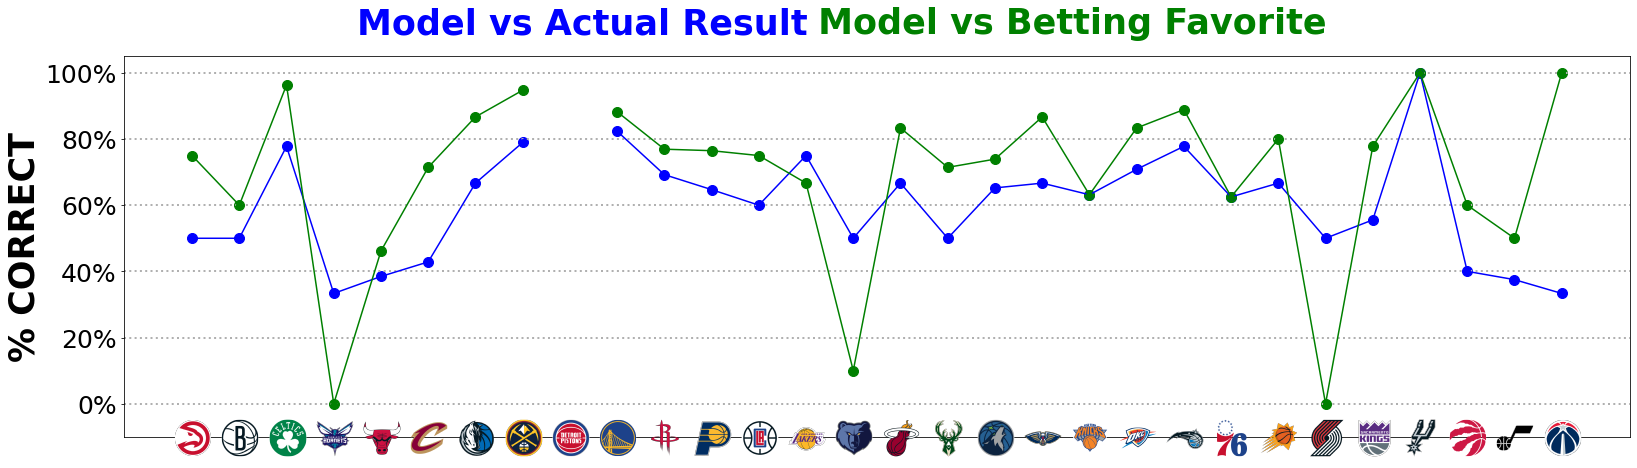

In [1730]:
fig, ax = plt.subplots(figsize = (27,7))
ax.get_xaxis().set_visible(False)
ymin = np.min([x for x in list(actualWinnerAccuracyByTeam['MODEL VS ACTUAL%'].values)+ list(bettingFavoriteAccuracyByTeam['MODEL VS BETTING FAVORITE%'].values) if not math.isnan(x)])
ymin = ymin - .1
ymax = np.max([x for x in list(actualWinnerAccuracyByTeam['MODEL VS ACTUAL%'].values)+ list(bettingFavoriteAccuracyByTeam['MODEL VS BETTING FAVORITE%'].values) if not math.isnan(x)])
ymax = ymax + .05
ax.set_ylim(ymin,ymax)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))  

# plt.title('Model vs Actual Result in blue & Model vs Betting Favorite in green',size=25,fontweight='bold')

# plt.title('Model vs Actual Result',size=25,fontweight='bold',color='blue')
# plt.title('Model vs Betting Favorite',size=25,fontweight='bold',color='green')
plt.ylabel('% CORRECT',size=35,fontweight='bold')
plt.yticks(fontsize=25)

ax.scatter(actualWinnerAccuracyByTeam.index,actualWinnerAccuracyByTeam['MODEL VS ACTUAL%'],marker='o',c='blue',s=100);
ax.plot(actualWinnerAccuracyByTeam.index,actualWinnerAccuracyByTeam['MODEL VS ACTUAL%'],marker='o',c='blue')

ax.scatter(bettingFavoriteAccuracyByTeam.index,bettingFavoriteAccuracyByTeam['MODEL VS BETTING FAVORITE%'],marker='o',c='green',s=100);
ax.plot(bettingFavoriteAccuracyByTeam.index,bettingFavoriteAccuracyByTeam['MODEL VS BETTING FAVORITE%'],marker='o',c='green')

for x, y, path in zip(actualWinnerAccuracyByTeam.index,np.full_like(actualWinnerAccuracyByTeam.index,ymin),paths):
    ab = AnnotationBbox(getImage(path),(x,ymin), frameon=False)
    ax.add_artist(ab)
    
ymax = np.max([x for x in list(actualWinnerAccuracyByTeam['MODEL VS ACTUAL%'].values)+ list(bettingFavoriteAccuracyByTeam['MODEL VS BETTING FAVORITE%'].values) if not math.isnan(x)])
ax.annotate('Model vs Actual Result\n',(3.5,ymax),fontsize=35,fontweight ='bold',color='blue')
ax.annotate(' Model vs Betting Favorite\n',(13,ymax),fontsize=35,fontweight ='bold',color='green')
plt.grid(linestyle=':',linewidth=2)
plt.show()

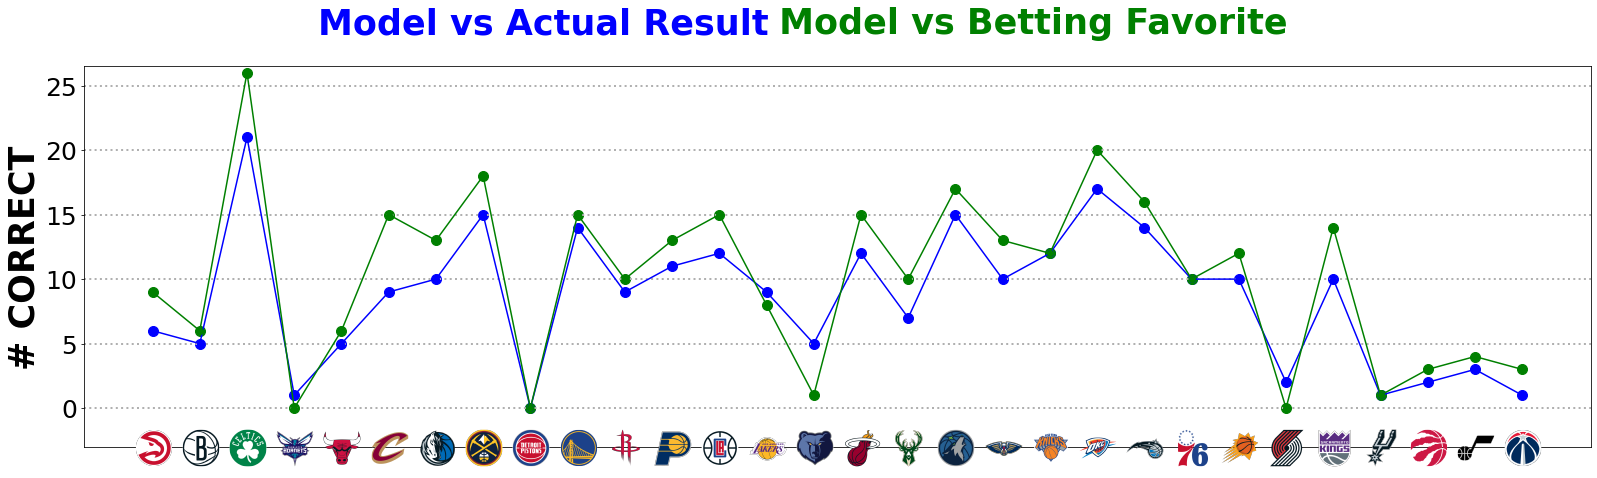

In [1731]:
fig, ax = plt.subplots(figsize = (27,7))
ax.get_xaxis().set_visible(False)
ymin = np.min([x for x in list(actualWinnerAccuracyByTeam['✅'].values)+ list(bettingFavoriteAccuracyByTeam['✅'].values) if not math.isnan(x)])
ymin = ymin - 3
ymax = np.max([x for x in list(actualWinnerAccuracyByTeam['✅'].values)+ list(bettingFavoriteAccuracyByTeam['✅'].values) if not math.isnan(x)])
ymax = ymax + .5
ax.set_ylim(ymin,ymax)
#plt.title('Model vs Actual Result in blue & Model vs Betting Favorite in green',size=25,fontweight='bold')
plt.ylabel('# CORRECT',size=35,fontweight='bold')
plt.yticks(fontsize=25)

ax.scatter(actualWinnerAccuracyByTeam.index,actualWinnerAccuracyByTeam['✅'],marker='o',c='blue',s=100);
ax.plot(actualWinnerAccuracyByTeam.index,actualWinnerAccuracyByTeam['✅'],marker='o',c='blue')

ax.scatter(bettingFavoriteAccuracyByTeam.index,bettingFavoriteAccuracyByTeam['✅'],marker='o',c='green',s=100);
ax.plot(bettingFavoriteAccuracyByTeam.index,bettingFavoriteAccuracyByTeam['✅'],marker='o',c='green')

for x, y, path in zip(actualWinnerAccuracyByTeam.index,np.full_like(actualWinnerAccuracyByTeam.index,ymin),paths):
    ab = AnnotationBbox(getImage(path),(x,ymin), frameon=False)
    ax.add_artist(ab)
    
ymax = np.max([x for x in list(actualWinnerAccuracyByTeam['✅'].values)+ list(bettingFavoriteAccuracyByTeam['✅'].values) if not math.isnan(x)])
ax.annotate('Model vs Actual Result\n',(3.5,ymax),fontsize=35,fontweight ='bold',color='blue')
ax.annotate(' Model vs Betting Favorite\n',(13,ymax),fontsize=35,fontweight ='bold',color='green')
plt.grid(linestyle=':',linewidth=2)
plt.show()

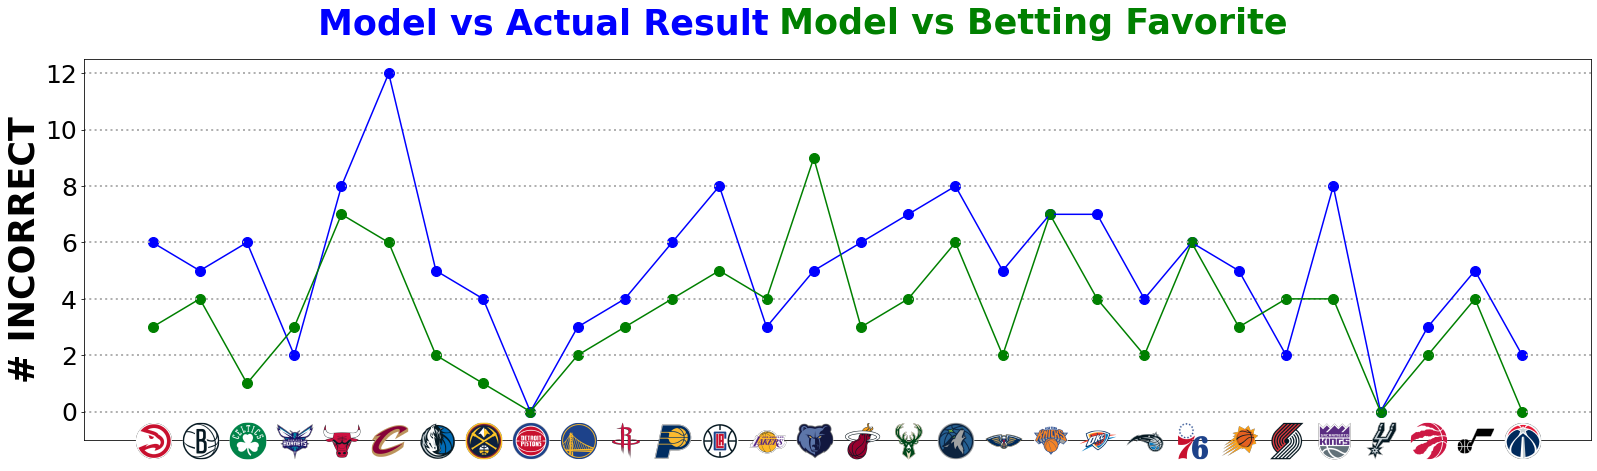

In [1732]:
fig, ax = plt.subplots(figsize = (27,7))
ax.get_xaxis().set_visible(False)
ymin = np.min([x for x in list(actualWinnerAccuracyByTeam['❌'].values)+ list(bettingFavoriteAccuracyByTeam['❌'].values) if not math.isnan(x)])
ymin = ymin - 1
ymax = np.max([x for x in list(actualWinnerAccuracyByTeam['❌'].values)+ list(bettingFavoriteAccuracyByTeam['❌'].values) if not math.isnan(x)])
ymax = ymax + .5
ax.set_ylim(ymin,ymax)
# plt.title('Model vs Actual Result in blue & Model vs Betting Favorite in green',size=25,fontweight='bold')
plt.ylabel('# INCORRECT',size=35,fontweight='bold')
plt.yticks(fontsize=25)

ax.scatter(actualWinnerAccuracyByTeam.index,actualWinnerAccuracyByTeam['❌'],marker='o',c='blue',s=100);
ax.plot(actualWinnerAccuracyByTeam.index,actualWinnerAccuracyByTeam['❌'],marker='o',c='blue')

ax.scatter(bettingFavoriteAccuracyByTeam.index,bettingFavoriteAccuracyByTeam['❌'],marker='o',c='green',s=100);
ax.plot(bettingFavoriteAccuracyByTeam.index,bettingFavoriteAccuracyByTeam['❌'],marker='o',c='green')

for x, y, path in zip(actualWinnerAccuracyByTeam.index,np.full_like(actualWinnerAccuracyByTeam.index,ymin),paths):
    ab = AnnotationBbox(getImage(path),(x,ymin), frameon=False)
    ax.add_artist(ab)

ymax = np.max([x for x in list(actualWinnerAccuracyByTeam['❌'].values)+ list(bettingFavoriteAccuracyByTeam['❌'].values) if not math.isnan(x)])
ax.annotate('Model vs Actual Result\n',(3.5,ymax),fontsize=35,fontweight ='bold',color='blue')
ax.annotate(' Model vs Betting Favorite\n',(13,ymax),fontsize=35,fontweight ='bold',color='green')

plt.grid(linestyle=':',linewidth=2)
plt.show()

NameError: name 'ylim' is not defined

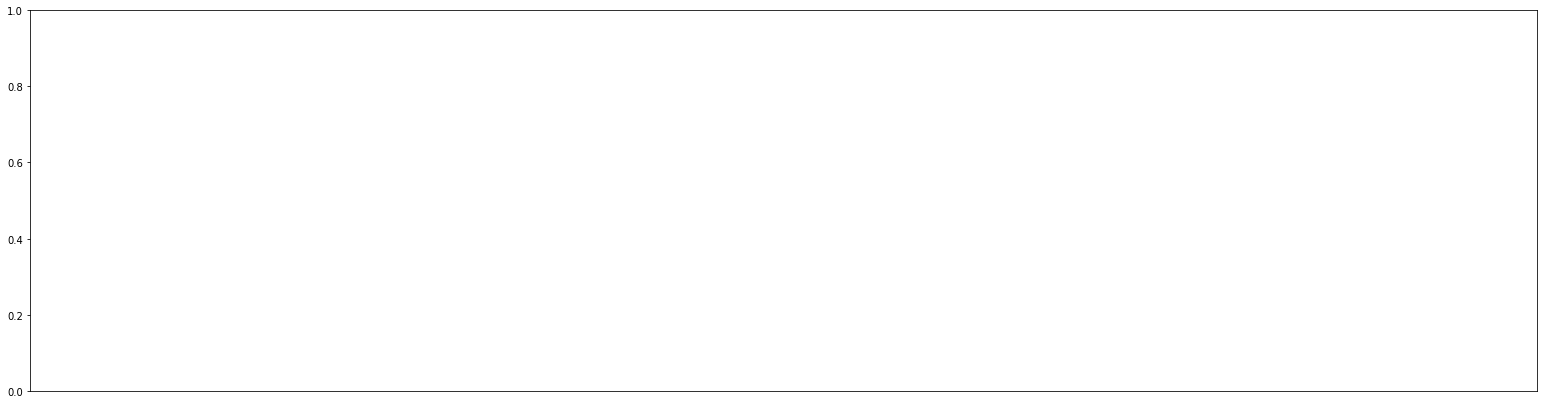

In [1670]:
fig, ax = plt.subplots(figsize = (27,7))
ax.get_xaxis().set_visible(False)
ymin = np.min([x for x in list(actualWinnerAccuracyByTeam['MODEL VS ACTUAL%'].values)+ list(bettingFavoriteAccuracyByTeam['MODEL VS BETTING FAVORITE%'].values) if not math.isnan(x)])
ymin = ymin - .1
ymax = np.max([x for x in list(actualWinnerAccuracyByTeam['MODEL VS ACTUAL%'].values)+ list(bettingFavoriteAccuracyByTeam['MODEL VS BETTING FAVORITE%'].values) if not math.isnan(x)])
ymax = ymax + .05
ax.set_ylim(ylim,ymax)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))  

plt.title('Model vs Actual Result in blue & Model vs Betting Favorite in green',size=25,fontweight='bold')
plt.ylabel('% CORRECT',size=25,fontweight='bold')
plt.yticks(fontsize=20)

ax.scatter(actualWinnerAccuracyByTeam.index,actualWinnerAccuracyByTeam['MODEL VS ACTUAL%'],marker='o',c='blue',s=100);
ax.plot(actualWinnerAccuracyByTeam.index,actualWinnerAccuracyByTeam['MODEL VS ACTUAL%'],marker='o',c='blue')

ax.scatter(bettingFavoriteAccuracyByTeam.index,bettingFavoriteAccuracyByTeam['MODEL VS BETTING FAVORITE%'],marker='o',c='green',s=100);
ax.plot(bettingFavoriteAccuracyByTeam.index,bettingFavoriteAccuracyByTeam['MODEL VS BETTING FAVORITE%'],marker='o',c='green')

for x, y, path in zip(actualWinnerAccuracyByTeam.index,np.full_like(actualWinnerAccuracyByTeam.index,ylim),paths):
    ab = AnnotationBbox(getImage(path),(x,ylim), frameon=False)
    ax.add_artist(ab)
plt.grid(linestyle=':',linewidth=2)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize = (27,7))
ax.get_xaxis().set_visible(False)
ymin = np.min([x for x in list(actualWinnerAccuracyByTeam['✅'].values)+ list(bettingFavoriteAccuracyByTeam['✅'].values) if not math.isnan(x)])
ymin = ymin - 3
ymax = np.max([x for x in list(actualWinnerAccuracyByTeam['✅'].values)+ list(bettingFavoriteAccuracyByTeam['✅'].values) if not math.isnan(x)])
ymax = ymax + .5
ax.set_ylim(ymin,ymax)
plt.title('Model vs Actual Result in blue & Model vs Betting Favorite in green',size=25,fontweight='bold')
plt.ylabel('# CORRECT',size=25,fontweight='bold')
plt.yticks(fontsize=20)

ax.scatter(actualWinnerAccuracyByTeam.index,actualWinnerAccuracyByTeam['✅'],marker='o',c='blue',s=100);
ax.plot(actualWinnerAccuracyByTeam.index,actualWinnerAccuracyByTeam['✅'],marker='o',c='blue')

ax.scatter(bettingFavoriteAccuracyByTeam.index,bettingFavoriteAccuracyByTeam['✅'],marker='o',c='green',s=100);
ax.plot(bettingFavoriteAccuracyByTeam.index,bettingFavoriteAccuracyByTeam['✅'],marker='o',c='green')

for x, y, path in zip(actualWinnerAccuracyByTeam.index,np.full_like(actualWinnerAccuracyByTeam.index,ymin),paths):
    ab = AnnotationBbox(getImage(path),(x,ymin), frameon=False)
    ax.add_artist(ab)
plt.grid(linestyle=':',linewidth=2)
plt.show()

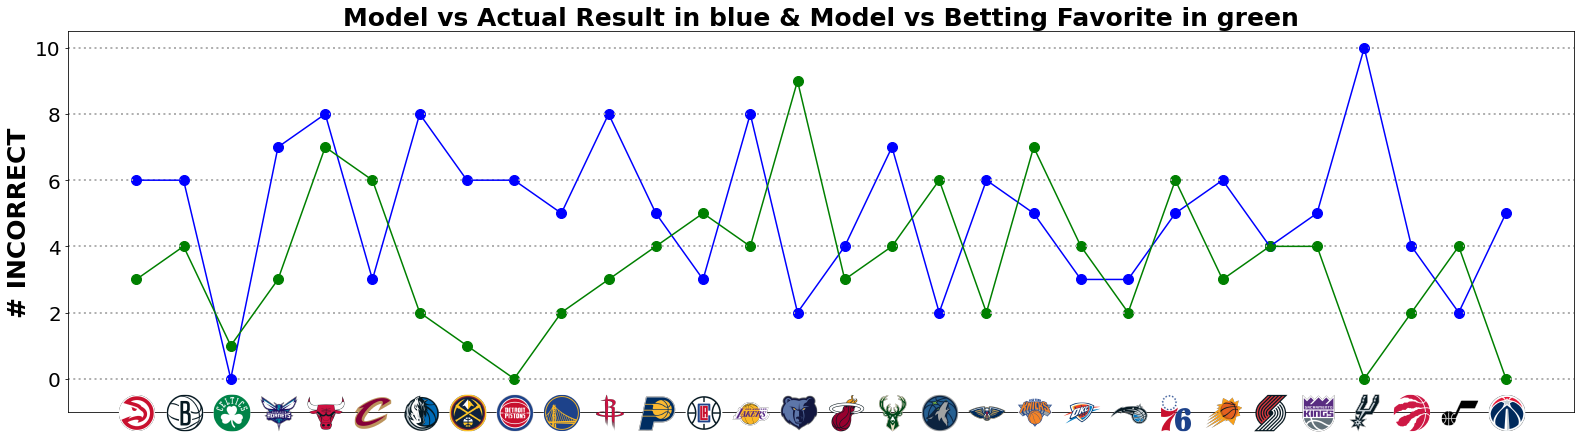

In [1671]:
fig, ax = plt.subplots(figsize = (27,7))
ax.get_xaxis().set_visible(False)
ymin = np.min([x for x in list(actualWinnerAccuracyByTeam['❌'].values)+ list(bettingFavoriteAccuracyByTeam['❌'].values) if not math.isnan(x)])
ymin = ymin - 1
ymax = np.max([x for x in list(actualWinnerAccuracyByTeam['❌'].values)+ list(bettingFavoriteAccuracyByTeam['❌'].values) if not math.isnan(x)])
ymax = ymax + .5
ax.set_ylim(ymin,ymax)
plt.title('Model vs Actual Result in blue & Model vs Betting Favorite in green',size=25,fontweight='bold')
plt.ylabel('# INCORRECT',size=25,fontweight='bold')
plt.yticks(fontsize=20)

ax.scatter(actualWinnerAccuracyByTeam.index,actualWinnerAccuracyByTeam['❌'],marker='o',c='blue',s=100);
ax.plot(actualWinnerAccuracyByTeam.index,actualWinnerAccuracyByTeam['❌'],marker='o',c='blue')

ax.scatter(bettingFavoriteAccuracyByTeam.index,bettingFavoriteAccuracyByTeam['❌'],marker='o',c='green',s=100);
ax.plot(bettingFavoriteAccuracyByTeam.index,bettingFavoriteAccuracyByTeam['❌'],marker='o',c='green')

for x, y, path in zip(actualWinnerAccuracyByTeam.index,np.full_like(actualWinnerAccuracyByTeam.index,ymin),paths):
    ab = AnnotationBbox(getImage(path),(x,ymin), frameon=False)
    ax.add_artist(ab)
plt.grid(linestyle=':',linewidth=2)
plt.show()

In [1758]:
2460/2

1230.0

In [ ]:
# DET = miscDF[miscDF['TEAM'] == 'DET']